**Tesla Stock**

In [1]:
import pandas as pd
import matplotlib#.pyplot as plt
import seaborn as sns #visualisation
%matplotlib inline
sns.set(color_codes=True)
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt

In [2]:
start_date = '2010-06-30'
end_date = '2020-11-30'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
tesladf = pdr.data.DataReader( "TSLA", 'yahoo', start_date, end_date)

In [3]:
tesladf.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-06-30,6.084,4.660,5.158,4.766,85935500.0,4.766
2010-07-01,5.184,4.054,5.000,4.392,41094000.0,4.392
2010-07-02,4.620,3.742,4.600,3.840,25699000.0,3.840
2010-07-06,4.000,3.166,4.000,3.222,34334500.0,3.222
2010-07-07,3.326,2.996,3.280,3.160,34608500.0,3.160


In [4]:
tesladf.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-11-23,526.000000,501.790009,503.500000,521.849976,50260300.0,521.849976
2020-11-24,559.989990,526.200012,540.400024,555.380005,53648500.0,555.380005
2020-11-25,574.000000,545.369995,550.059998,574.000000,48930200.0,574.000000
2020-11-27,598.780029,578.450012,581.159973,585.760010,37561100.0,585.760010
2020-11-30,607.799988,554.510010,602.210022,567.599976,63003100.0,567.599976


In [5]:
tesladf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2624 entries, 2010-06-30 to 2020-11-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2624 non-null   float64
 1   Low        2624 non-null   float64
 2   Open       2624 non-null   float64
 3   Close      2624 non-null   float64
 4   Volume     2624 non-null   float64
 5   Adj Close  2624 non-null   float64
dtypes: float64(6)
memory usage: 143.5 KB


In [6]:
tesladf.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2624.000000,2624.000000,2624.000000,2624.000000,2.624000e+03,2624.000000
mean,57.222118,54.711097,55.991704,56.022998,3.155862e+07,56.022998
std,79.442284,74.995563,77.286748,77.366423,2.909417e+07,77.366423
min,3.326000,2.996000,3.228000,3.160000,5.925000e+05,3.160000
25%,7.566500,7.289500,7.337000,7.389500,1.103238e+07,7.389500
50%,45.034000,43.619999,44.373999,44.206001,2.473925e+07,44.206001
75%,61.358000,59.069501,60.201000,60.244499,4.083925e+07,60.244499
max,607.799988,578.450012,602.210022,585.760010,3.046940e+08,585.760010


Text(0.5, 1.0, 'Closing Prices')

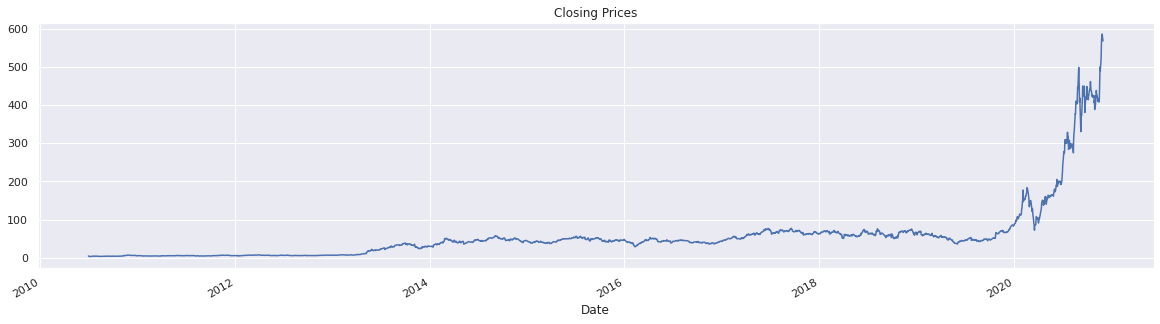

In [7]:
tesladf['Close'].plot(figsize=(20,5))
plt.title('Closing Prices')

https://mlcourse.ai/articles/topic9-part1-time-series/

In [9]:
import warnings                                  
warnings.filterwarnings('ignore')

import numpy as np # vectors and matrices
import pandas as pd # tables and data manipulations
import matplotlib.pyplot as plt                  
import seaborn as sns                            

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize # for function minimization

import statsmodels.formula.api as smf # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product # some useful functions
from tqdm import tqdm_notebook

%matplotlib inline

**Move, smoothe and evaluate**

we'll assume the future value depends on the average of its k previous values, therefore we are using MA

In [10]:
def moving_average(series, n):
    """Calculate average of last n observations"""
    return np.average(series[-n:])
moving_average(tesladf['Close'], 12) # prediction for the last observed day for the past 12 hours

495.8391621907552

in order to get the value for the next step, previous values needs to be observed with MA it's use is to smooth the orginal series to indetify trends using the function rolling(window).mean
with a wider window the smoother the trend. with a noisy data this can help detect common patterns

**Weighted Average = larger weights assigned to more recent observations**

In [11]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [12]:
weighted_average(tesladf['Close'], [0.6, 0.3, 0.1])

573.68798828125

In [13]:
0.6 * tesladf['Close'].iloc[-1] + 0.3 * tesladf['Close'].iloc[-2] + 0.1 * tesladf['Close'].iloc[-3]

573.68798828125

**Exponential Smoothing**

In [14]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [15]:
def plotExponentialSmoothing(series, alphas):
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

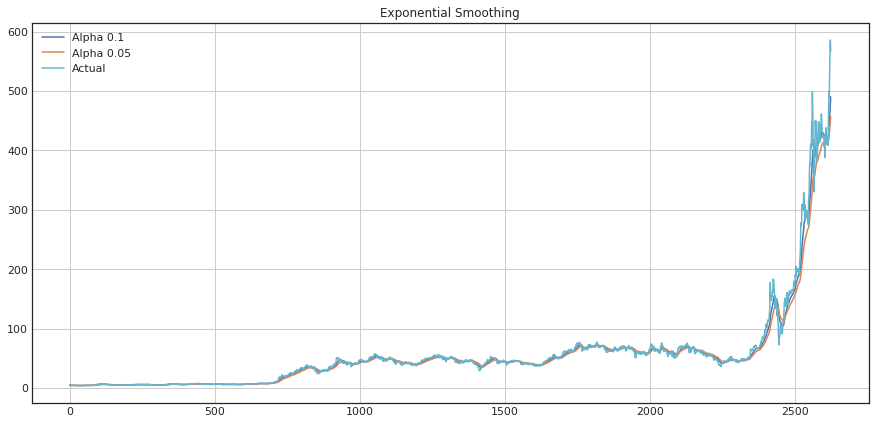

In [16]:
plotExponentialSmoothing(tesladf.Close, [0.10, 0.05]) #CI of 90 and 95%

**Double Exponential Smoothing**

In [17]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

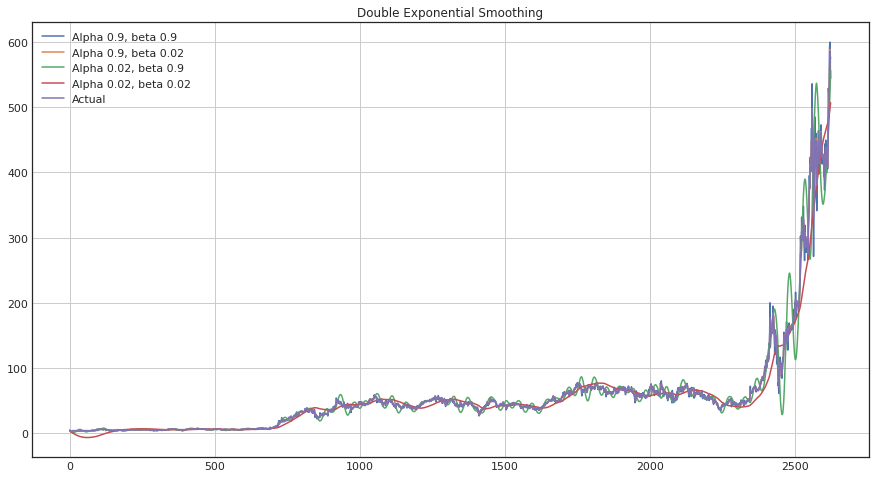

In [18]:
plotDoubleExponentialSmoothing(tesladf.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

Stationarity is important since it makes predictions easy

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

**Time series**

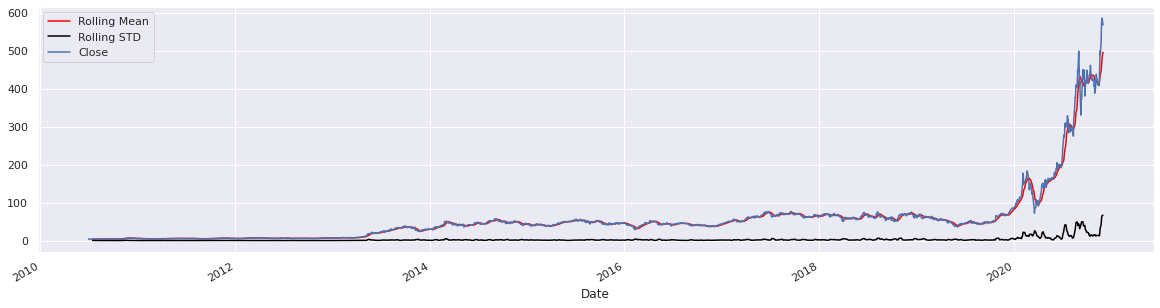

In [19]:
timeseries = tesladf['Close']
timeseries.rolling(12).mean().plot(label = 'Rolling Mean', color = 'red')
timeseries.rolling(12).std().plot(label = 'Rolling STD', color = 'black')
timeseries.plot(figsize=(20,5))
plt.legend()
#rolling average is the closing prices for the first 12 days

Decomposition

<Figure size 432x288 with 0 Axes>

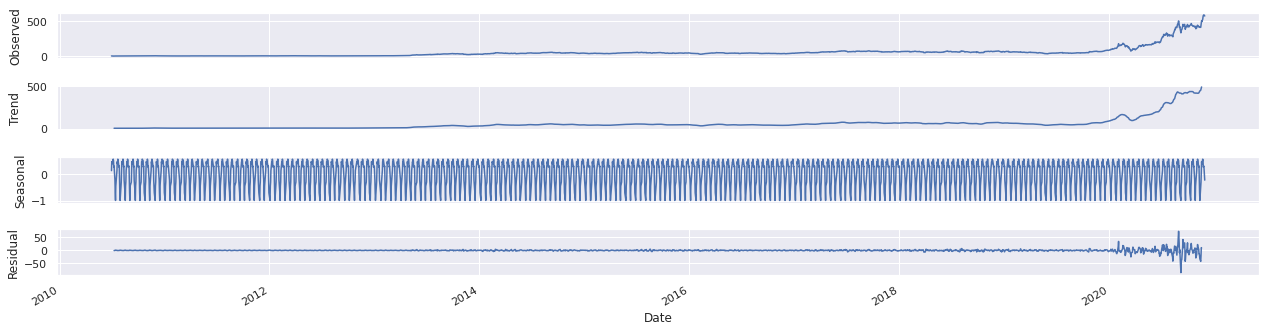

In [20]:
decomposition = sm.tsa.seasonal_decompose(tesladf['Close'], freq=12)  
figure = plt.figure()  
figure = decomposition.plot()  
figure.set_size_inches(20,5)

from the results in decomposition, the data seem to show trend and seasonality.
We then check if the data is stationary or not by performing a test called ADF - this test the null hypothesis

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/#:~:text=So%20what%20exactly%20is%20an,used%20to%20forecast%20future%20values

In [21]:
from statsmodels.tsa.stattools import adfuller

In [22]:
result = adfuller(tesladf['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('No. of lags Used: %f' % result[2])
print('No. of Observation Used: %f' % result[3])

ADF Statistic: 7.342893
p-value: 1.000000
No. of lags Used: 28.000000
No. of Observation Used: 2595.000000


p value is > 0.05 which means data is not stationary so we do further differencing

In [23]:
def check_adf(time_series):
    test_result = adfuller(time_series)
    labels = ['ADF Statistic','p-value','No. of Lags Used','Number of Observations Used']
    for value,label in zip(test_result,labels):
      print (label+': '+str(value))

In [24]:
tesladf['Close Tesla First Difference'] = tesladf['Close'] - tesladf['Close'].shift(1)
check_adf(tesladf['Close Tesla First Difference'].dropna())

ADF Statistic: -7.524887020659134
p-value: 3.7071891111434244e-11
No. of Lags Used: 28
Number of Observations Used: 2594


with the result p < 0.05 meaning data is now stationary

**ACF and PACF** plots to determine p nad q values.
PACF gives its own lagged values
ACF gives own lagged values without controlling the other lags

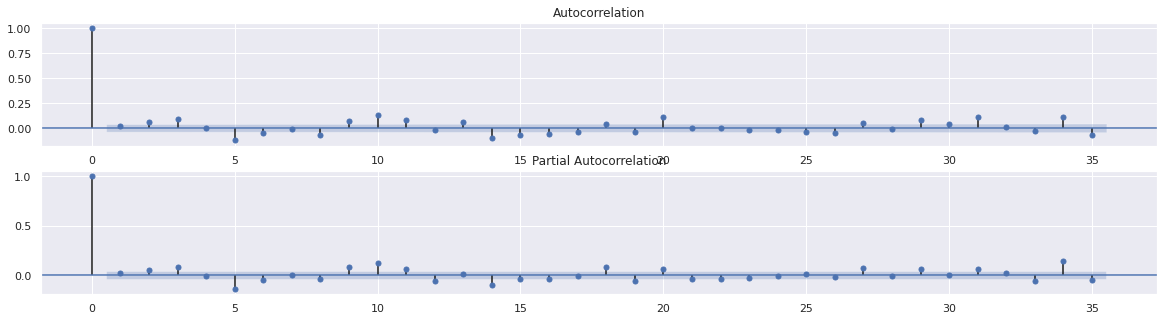

In [25]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(tesladf['Close Tesla First Difference'].dropna(),ax=ax1)
fig = sm.graphics.tsa.plot_pacf(tesladf['Close Tesla First Difference'].dropna(),ax=ax2)

or using **pmdarima** library to figure out the order of ARIMA

https://medium.com/swlh/temperature-forecasting-with-arima-model-in-python-427b2d3bcb53

In [ ]:
pip install pmdarima

In [27]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [28]:
stepwise_fit = auto_arima(tesladf['Close'],trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=1.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=17248.034, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=16428.094, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=16054.211, Time=0.22 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=15946.824, Time=0.32 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=15938.893, Time=0.40 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=15891.304, Time=0.46 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=1.80 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=1.37 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=15893.299, Time=1.23 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 7.397 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 2624
Model:               SARIMAX(5, 2, 0)   Log Likelihood               -7939.652
Date:                Fri, 14 May 2021   AIC                          15891.304
Time:                        10:39:11   BIC                          15926.534
Sample:                             0   HQIC                         15904.063
                               - 2624                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8090      0.005   -169.845      0.000      -0.818      -0.800
ar.L2         -0.5817      0.007    -89.162      0.000      -0.594      -0.569
ar.L3         -0.3307      0.005    -60.263      0.000      -0.341      -0.320
ar.L4         -0.1755      0.005    -37.725      0.000      -0.185      -0.166
ar.L5         -0.1402      0.005    -28.902      0.000      -0.150      -0.131
sigma2        24.9776      0.140    178.075      0.000      24.703      25.253
===================================================================================
Ljung-Box (Q):                      712.84   Jarque-Bera (JB):            348187.48
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             209.75   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        59.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

It chooses 5,2,0 as the best model with the AIC score
lowest AIC score is the best fit 

**Splitting dataset for training and testing**

In [29]:
from statsmodels.tsa.arima_model import ARIMA

training the model in the train section and checking if it is good or not in the test section

In [30]:
print(tesladf.shape)
train = tesladf.iloc[:-30]
test=tesladf.iloc[-30:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1])

(2624, 7)
(2594, 7) (30, 7)
High                            4.470000e+02
Low                             4.288700e+02
Open                            4.462400e+02
Close                           4.308300e+02
Volume                          3.628780e+07
Adj Close                       4.308300e+02
Close Tesla First Difference   -8.840027e+00
Name: 2020-10-19 00:00:00, dtype: float64 High                            6.078000e+02
Low                             5.545100e+02
Open                            6.022100e+02
Close                           5.676000e+02
Volume                          6.300310e+07
Adj Close                       5.676000e+02
Close Tesla First Difference   -1.816003e+01
Name: 2020-11-30 00:00:00, dtype: float64


fitting the model is calling the ARIMA function with model.fit - **Training the model**

In [31]:
model= ARIMA(train['Close'],order=(5,2,0))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.Close   No. Observations:                 2592
Model:                 ARIMA(5, 2, 0)   Log Likelihood               -7654.845
Method:                       css-mle   S.D. of innovations              4.637
Date:                Fri, 14 May 2021   AIC                          15323.690
Time:                        10:39:22   BIC                          15364.711
Sample:                             2   HQIC                         15338.555
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0009      0.031     -0.028      0.978      -0.061       0.059
ar.L1.D2.Close    -0.8333      0.019    -42.806      0.000      -0.871      -0.795
ar.L2.D2.Close    -0.5717      0.025    -22.466      0.000      -0.622      -0.522
ar.L3.D2.Close    -0.2825      0.027    -10.352      0.000      -0.336      -0.229
ar.L4.D2.Close    -0.1279      0.025     -5.027      0.000      -0.178      -0.078
ar.L5.D2.Close    -0.1463      0.020     -7.488      0.000      -0.185      -0.108
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3456           -0.0000j            1.3456           -0.5000
AR.2           -0.6107           -1.1881j            1.3359           -0.3256
AR.3           -0.6107           +1.1881j            1.3359            0.3256
AR.4            0.8461           -1.4599j            1.6874           -0.1664
AR.5            0.8461           +1.4599j            1.6874            0.1664
-----------------------------------------------------------------------------
"""

**Make predictions on Test Set**

In [32]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
pred=model.predict(start=start,end=end,typ='levels')
pred.index = tesladf.index[start:end+1]
print(pred)

Date
2020-10-19    440.823324
2020-10-20    438.409573
2020-10-21    434.090674
2020-10-22    434.017657
2020-10-23    430.705484
2020-10-26    427.141122
2020-10-27    425.202485
2020-10-28    422.701204
2020-10-29    419.601375
2020-10-30    417.366297
2020-11-02    414.738134
2020-11-03    411.943852
2020-11-04    409.424818
2020-11-05    406.856816
2020-11-06    404.140452
2020-11-09    401.574185
2020-11-10    398.968053
2020-11-11    396.314709
2020-11-12    393.704717
2020-11-13    391.096822
2020-11-16    388.456347
2020-11-17    385.838919
2020-11-18    383.219152
2020-11-19    380.588223
2020-11-20    377.962756
2020-11-23    375.339068
2020-11-24    372.708327
2020-11-25    370.080145
2020-11-27    367.451767
2020-11-30    364.820526
dtype: float64


plotting prediction and test set along with it. Based on the results the model is not built well

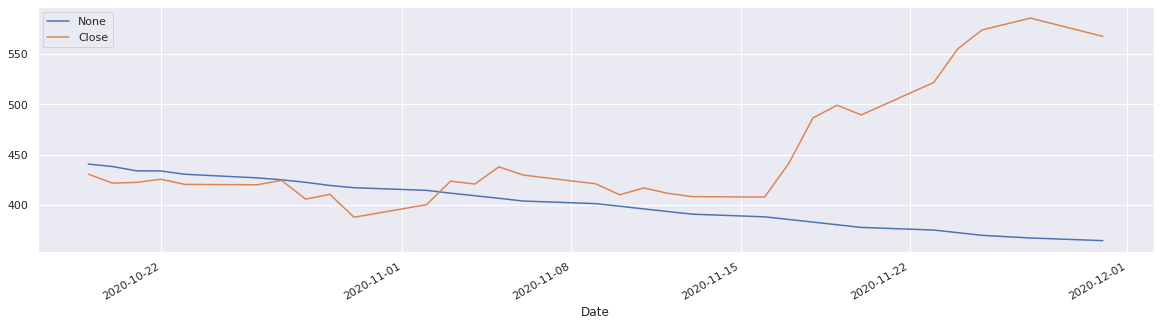

In [33]:
pred.plot(figsize = (20,5), legend = True)
test['Close'].plot(legend = True)

from the results the predicted values are not that great and from rmse we can see what the average error is

In [34]:
test['Close'].mean()

449.4643320719401

In [35]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(pred, test['Close']))
print(rmse)

87.85820884642216


root mean squared should be smaller than the mean value of test set. We have an average error of 19.5%
87.9/449.5 * 100 = 19.5%

In [36]:
model2 = ARIMA(tesladf['Close'],order = (5,2,0))
model2 = model2.fit()
tesladf.tail()

,High,Low,Open,Close,Volume,Adj Close,Close Tesla First Difference
Date,,,,,,,
2020-11-23,526.000000,501.790009,503.500000,521.849976,50260300.0,521.849976,32.239990
2020-11-24,559.989990,526.200012,540.400024,555.380005,53648500.0,555.380005,33.530029
2020-11-25,574.000000,545.369995,550.059998,574.000000,48930200.0,574.000000,18.619995
2020-11-27,598.780029,578.450012,581.159973,585.760010,37561100.0,585.760010,11.760010
2020-11-30,607.799988,554.510010,602.210022,567.599976,63003100.0,567.599976,-18.160034


**Predicting Future Dates**

retrain the model as an entire dataset

In [37]:
index_future_dates = pd.date_range(start = '2020-11-30', end = '2020-12-30')
#pred.index = index_future_dates
pred = model2.predict(start = len(tesladf),end=len(tesladf)+30,typ = 'levels').rename('ARIMA Predictions')
#print(comp_pred)
pred.index = index_future_dates
print(pred)

2020-11-30    576.478945
2020-12-01    585.601909
2020-12-02    591.996985
2020-12-03    597.732566
2020-12-04    604.964218
2020-12-05    608.444387
2020-12-06    614.759547
2020-12-07    620.974028
2020-12-08    626.698713
2020-12-09    632.396217
2020-12-10    638.469530
2020-12-11    644.043924
2020-12-12    649.919596
2020-12-13    655.798048
2020-12-14    661.609023
2020-12-15    667.415335
2020-12-16    673.287984
2020-12-17    679.096415
2020-12-18    684.938360
2020-12-19    690.786037
2020-12-20    696.626985
2020-12-21    702.468077
2020-12-22    708.321346
2020-12-23    714.168351
2020-12-24    720.020822
2020-12-25    725.876556
2020-12-26    731.733537
2020-12-27    737.592346
2020-12-28    743.454943
2020-12-29    749.318812
2020-12-30    755.185318
Freq: D, Name: ARIMA Predictions, dtype: float64


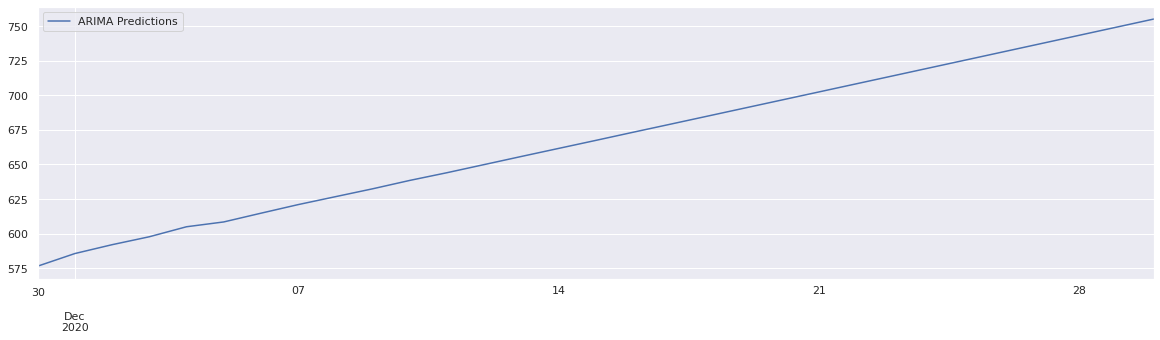

In [38]:
pred.plot(figsize = (20,5),legend = True)

Predicted next 30 days shows a continous increase in values

**BMW**

In [39]:
start_date = '1996-11-09'
end_date = '2020-11-30'

bmwdf = pdr.data.DataReader( "BMW.DE", 'yahoo', start_date, end_date)

In [40]:
from google.colab import files
bmwdf.to_csv('bmw.csv') 
#files.download('bmw.csv')

In [41]:
bmwdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6170 entries, 1996-11-11 to 2020-11-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       6170 non-null   float64
 1   Low        6170 non-null   float64
 2   Open       6170 non-null   float64
 3   Close      6170 non-null   float64
 4   Volume     6170 non-null   float64
 5   Adj Close  6170 non-null   float64
dtypes: float64(6)
memory usage: 337.4 KB


In [42]:
bmwdf.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1996-11-11,18.200001,18.082001,18.190001,18.122000,260000.0,10.014695
1996-11-12,18.327999,18.091999,18.160999,18.259001,1066000.0,10.090405
1996-11-13,18.344000,18.190001,18.344000,18.230000,793000.0,10.074377
1996-11-14,18.289000,18.132000,18.205000,18.289000,351000.0,10.106983
1996-11-15,18.440001,18.268999,18.308001,18.438000,624000.0,10.189323


In [43]:
bmwdf.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-11-24,76.680000,74.599998,74.849998,76.680000,1844609.0,73.215469
2020-11-25,77.309998,74.639999,77.000000,75.400002,1489748.0,71.993309
2020-11-26,75.320000,73.669998,75.300003,74.129997,1215517.0,70.780685
2020-11-27,73.809998,72.599998,73.769997,73.089996,1699488.0,69.787666
2020-11-30,73.760002,72.250000,72.510002,73.040001,1921018.0,69.739929


In [44]:
def moving_average(series,n):
  return np.average(series[-n:])
moving_average(bmwdf['Close'],12)

73.71916643778484

In [45]:
def weighted_average(series, weights):
  result = 0.0
  for n in range(len(weights)):
    result += series.iloc[-n-1] * weights[n]
  return float(result)

weighted_average(bmwdf['Close'],[0.6,0.3,0.1])

73.16399917602538

**Exponential Smoothing**

In [46]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

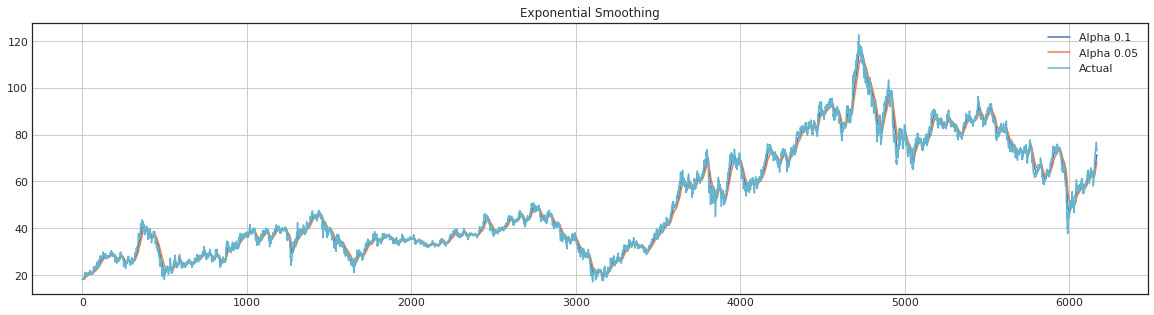

In [47]:
def plotExponentialSmoothing(series, alphas):
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20,5))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

plotExponentialSmoothing(bmwdf.Close, [0.10, 0.05]) #CI of 90 and 95%

**Double Exponential Smoothing**

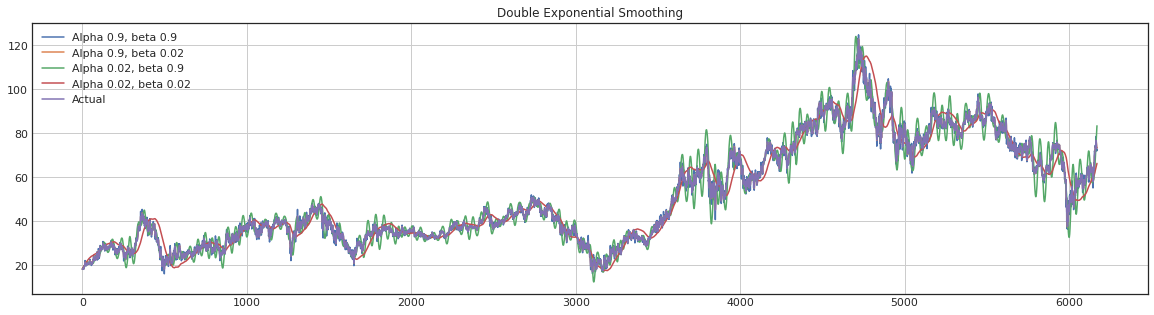

In [48]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20,5))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

plotDoubleExponentialSmoothing(bmwdf.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

**Time Series**

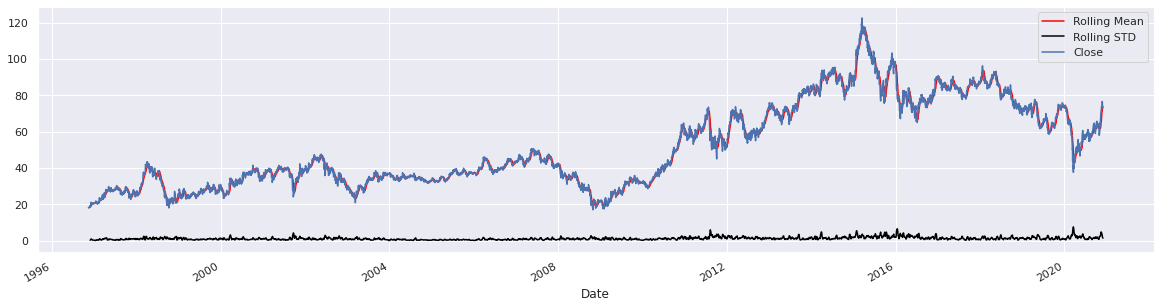

In [49]:
bmw_timeseries = bmwdf['Close']
bmw_timeseries.rolling(12).mean().plot(label = 'Rolling Mean', color = 'red')
bmw_timeseries.rolling(12).std().plot(label = 'Rolling STD', color = 'black')
bmw_timeseries.plot(figsize=(20,5))
plt.legend()

<Figure size 432x288 with 0 Axes>

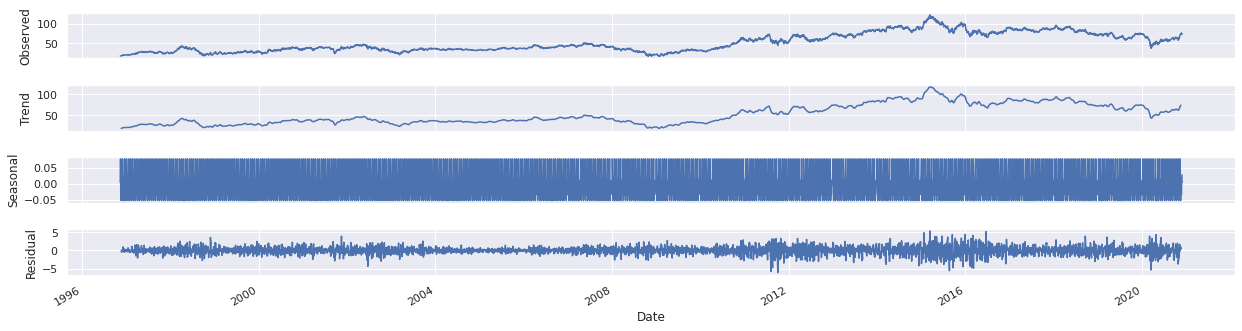

In [50]:
decomposition = sm.tsa.seasonal_decompose(bmwdf['Close'], freq=12)  
figure = plt.figure()  
figure = decomposition.plot()  
figure.set_size_inches(20,5)

**ADF to check stationarity**

In [51]:
from statsmodels.tsa.stattools import adfuller

In [52]:
result = adfuller(bmwdf['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('No. of lags Used: %f' % result[2])
print('No. of Observation Used: %f' % result[3])

ADF Statistic: -1.839733
p-value: 0.360921
No. of lags Used: 20.000000
No. of Observation Used: 6149.000000


In [53]:
def check_adf(time_series):
    test_result = adfuller(time_series)
    labels = ['ADF Statistic','p-value','No. of Lags Used','Number of Observations Used']
    for value,label in zip(test_result,labels):
      print (label+': '+str(value))

In [54]:
bmwdf['Close BMW First Difference'] = bmwdf['Close'] - bmwdf['Close'].shift(1)
check_adf(bmwdf['Close BMW First Difference'].dropna())

ADF Statistic: -16.966047186871116
p-value: 9.2327244193333e-30
No. of Lags Used: 19
Number of Observations Used: 6149


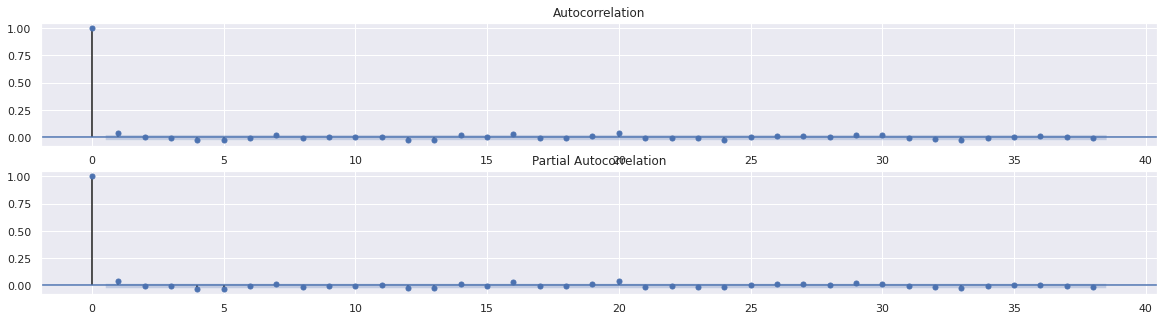

In [55]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(bmwdf['Close BMW First Difference'].dropna(),ax=ax1)
fig = sm.graphics.tsa.plot_pacf(bmwdf['Close BMW First Difference'].dropna(),ax=ax2)

In [56]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [57]:
stepwise_fit = auto_arima(bmwdf['Close'],trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17608.676, Time=3.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17609.259, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17602.722, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17602.702, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17607.740, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17604.702, Time=0.98 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=17604.701, Time=0.95 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=17606.701, Time=1.28 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=17601.150, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=17603.150, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=17603.150, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=17601.169, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=17605.149, Time=0.48 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 9.599 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 6170
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -8798.575
Date:                Fri, 14 May 2021   AIC                          17601.150
Time:                        10:41:05   BIC                          17614.605
Sample:                             0   HQIC                         17605.816
                               - 6170                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0373      0.010      3.866      0.000       0.018       0.056
sigma2         1.0147      0.011     95.203      0.000       0.994       1.036
===================================================================================
Ljung-Box (Q):                       61.87   Jarque-Bera (JB):              3895.41
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               2.47   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Splitting dataset**

In [58]:
from statsmodels.tsa.arima_model import ARIMA

In [59]:
print(bmwdf.shape)
train = bmwdf.iloc[:-30]
test=bmwdf.iloc[-30:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1])

(6170, 7)
(6140, 7) (30, 7)
High                          6.428000e+01
Low                           6.241000e+01
Open                          6.350000e+01
Close                         6.407000e+01
Volume                        1.491163e+06
Adj Close                     6.117521e+01
Close BMW First Difference    4.500008e-01
Name: 2020-10-20 00:00:00, dtype: float64 High                          7.376000e+01
Low                           7.225000e+01
Open                          7.251000e+01
Close                         7.304000e+01
Volume                        1.921018e+06
Adj Close                     6.973993e+01
Close BMW First Difference   -4.999542e-02
Name: 2020-11-30 00:00:00, dtype: float64


**Training the model**

In [60]:
model= ARIMA(train['Close'],order=(0,1,1))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 6139
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -8737.620
Method:                       css-mle   S.D. of innovations              1.004
Date:                Fri, 14 May 2021   AIC                          17481.241
Time:                        10:41:14   BIC                          17501.408
Sample:                             1   HQIC                         17488.236
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0074      0.013      0.558      0.577      -0.019       0.033
ma.L1.D.Close     0.0360      0.013      2.812      0.005       0.011       0.061
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1          -27.7878           +0.0000j           27.7878            0.5000
-----------------------------------------------------------------------------
"""

**Predictions on Test set**

In [61]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
pred=model.predict(start=start,end=end,typ='levels')
pred.index = bmwdf.index[start:end+1]
print(pred)

Date
2020-10-20    63.643831
2020-10-21    63.651245
2020-10-22    63.658660
2020-10-23    63.666075
2020-10-26    63.673490
2020-10-27    63.680905
2020-10-28    63.688319
2020-10-29    63.695734
2020-10-30    63.703149
2020-11-02    63.710564
2020-11-03    63.717979
2020-11-04    63.725394
2020-11-05    63.732808
2020-11-06    63.740223
2020-11-09    63.747638
2020-11-10    63.755053
2020-11-11    63.762468
2020-11-12    63.769882
2020-11-13    63.777297
2020-11-16    63.784712
2020-11-17    63.792127
2020-11-18    63.799542
2020-11-19    63.806956
2020-11-20    63.814371
2020-11-23    63.821786
2020-11-24    63.829201
2020-11-25    63.836616
2020-11-26    63.844031
2020-11-27    63.851445
2020-11-30    63.858860
dtype: float64


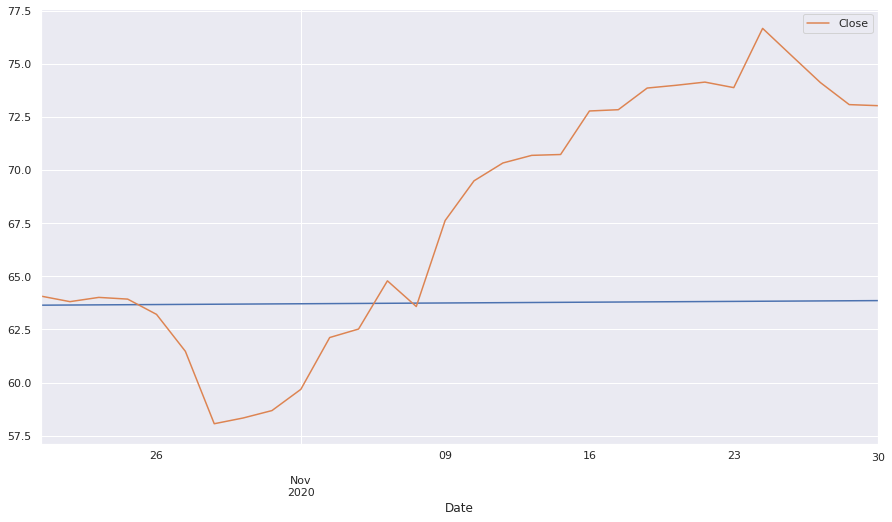

In [62]:
pred.plot(figsize = (15,8))
test['Close'].plot(legend = True)

In [63]:
test['Close'].mean()

67.70199991861979

In [64]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(pred, test['Close']))
print(rmse)

6.955556234818989


root mean squared < mean value of test set. We have an average error of 6.9/67.70 * 100 = 10.2 % error

In [65]:
model3 = ARIMA(bmwdf['Close'],order = (0,1,1))
model3 = model3.fit()
bmwdf.tail()

,High,Low,Open,Close,Volume,Adj Close,Close BMW First Difference
Date,,,,,,,
2020-11-24,76.680000,74.599998,74.849998,76.680000,1844609.0,73.215469,2.790001
2020-11-25,77.309998,74.639999,77.000000,75.400002,1489748.0,71.993309,-1.279999
2020-11-26,75.320000,73.669998,75.300003,74.129997,1215517.0,70.780685,-1.270004
2020-11-27,73.809998,72.599998,73.769997,73.089996,1699488.0,69.787666,-1.040001
2020-11-30,73.760002,72.250000,72.510002,73.040001,1921018.0,69.739929,-0.049995


**Future Dates**

In [66]:
index_future_dates = pd.date_range(start = '2020-11-30', end = '2020-12-30')
#pred.index = index_future_dates
pred = model3.predict(start = len(bmwdf),end=len(bmwdf)+30,typ = 'levels').rename('ARIMA Predictions')
#print(comp_pred)
pred.index = index_future_dates
print(pred)

2020-11-30    73.048102
2020-12-01    73.057005
2020-12-02    73.065908
2020-12-03    73.074811
2020-12-04    73.083714
2020-12-05    73.092617
2020-12-06    73.101520
2020-12-07    73.110423
2020-12-08    73.119325
2020-12-09    73.128228
2020-12-10    73.137131
2020-12-11    73.146034
2020-12-12    73.154937
2020-12-13    73.163840
2020-12-14    73.172743
2020-12-15    73.181646
2020-12-16    73.190549
2020-12-17    73.199452
2020-12-18    73.208355
2020-12-19    73.217258
2020-12-20    73.226161
2020-12-21    73.235063
2020-12-22    73.243966
2020-12-23    73.252869
2020-12-24    73.261772
2020-12-25    73.270675
2020-12-26    73.279578
2020-12-27    73.288481
2020-12-28    73.297384
2020-12-29    73.306287
2020-12-30    73.315190
Freq: D, Name: ARIMA Predictions, dtype: float64


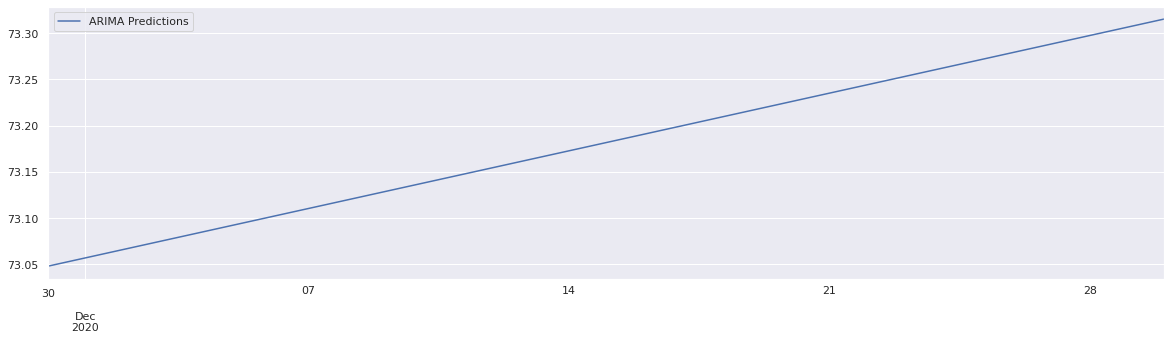

In [67]:
pred.plot(figsize = (20,5), legend = True)

continuous increase in predicted values

**Crude Oil**

In [68]:
#Title: Ways to import CSV files in Google Colab using Pydrive
#Item type: Blog Post
#Author: GeeksforGeeks
#Availability: https://www.geeksforgeeks.org/ways-to-import-csv-files-in-google-colab/

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [69]:
link = 'https://drive.google.com/file/d/1bDmksCT2qU5xelMH8IpulvcfM9r9lnPz/view?usp=sharing'

In [70]:
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('crudeoil.csv')
oildf = pd.read_csv('crudeoil.csv')

In [71]:
from google.colab import files
oildf.to_csv('crudeoil.csv')

In [72]:
oildf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6244 entries, 0 to 6243
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6244 non-null   object 
 1   Open       5099 non-null   float64
 2   High       5099 non-null   float64
 3   Low        5099 non-null   float64
 4   Close      5099 non-null   float64
 5   Adj Close  5099 non-null   float64
 6   Volume     5099 non-null   float64
dtypes: float64(6), object(1)
memory usage: 341.6+ KB


In [ ]:
#oildf ['Date'] = oildf['Date'].apply(pd.to_datetime)

In [ ]:
#oildf = oildf.reset_index()

In [ ]:
#oildf['Date']=oildf['Date'].astype('datetime64[ns]')

In [73]:
oildf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-03-22,27.65,28.250000,27.250000,27.459999,27.459999,92302.0
1,2000-03-23,27.65,27.780001,27.160000,27.309999,27.309999,79373.0
2,2000-03-24,27.85,28.150000,27.549999,27.980000,27.980000,55693.0
3,2000-03-26,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-03-27,27.65,28.020000,27.410000,27.730000,27.730000,59199.0


In [74]:
oildf.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
6239,2020-07-16,40.900002,41.139999,40.520000,40.759998,40.759998,77425275.0
6240,2020-07-17,40.740002,40.900002,40.020000,40.570000,40.570000,28236139.0
6241,2020-07-19,40.639999,40.650002,40.459999,40.630001,40.630001,7030.0
6242,2020-07-20,40.360001,40.910000,39.830002,40.650002,40.650002,8747221.0
6243,2020-07-21,40.840000,42.400002,40.840000,41.759998,41.759998,1323868.0


In [75]:
print(oildf.isnull().sum())

Date            0
Open         1145
High         1145
Low          1145
Close        1145
Adj Close    1145
Volume       1145
dtype: int64


In [76]:
oildf = oildf.dropna()

In [77]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [78]:
def moving_average(series, n):
    """Calculate average of last n observations"""
    return np.average(series[-n:])
moving_average(oildf['Close'], 12) # prediction for the last observed day for the past 12 hours

40.64916641666667

In [79]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [80]:
weighted_average(oildf['Close'], [0.6, 0.3, 0.1])

41.313999499999994

In [81]:
0.6 * oildf['Close'].iloc[-1] + 0.3 * oildf['Close'].iloc[-2] + 0.1 * oildf['Close'].iloc[-3]

41.313999499999994

**Time Series**

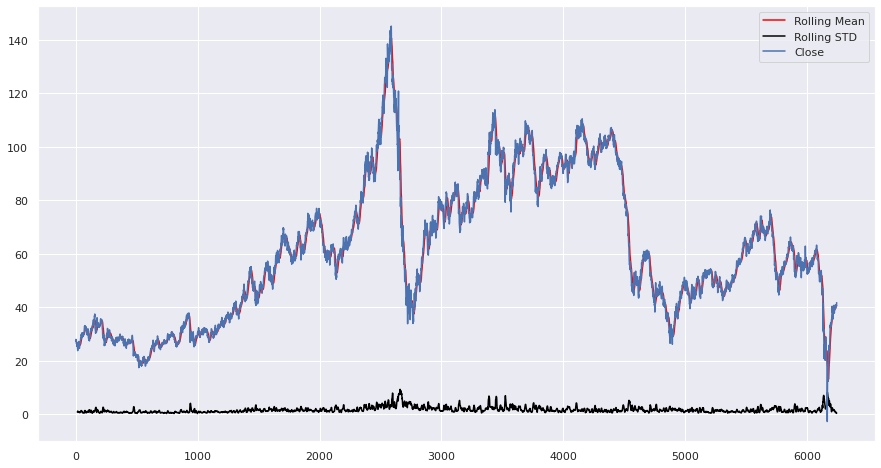

In [82]:
timeseries = oildf['Close']
timeseries.rolling(12).mean().plot(label = 'Rolling Mean', color = 'red')
timeseries.rolling(12).std().plot(label = 'Rolling STD', color = 'black')
timeseries.plot(figsize=(15,8))
plt.legend()

**Decomposition**

<Figure size 432x288 with 0 Axes>

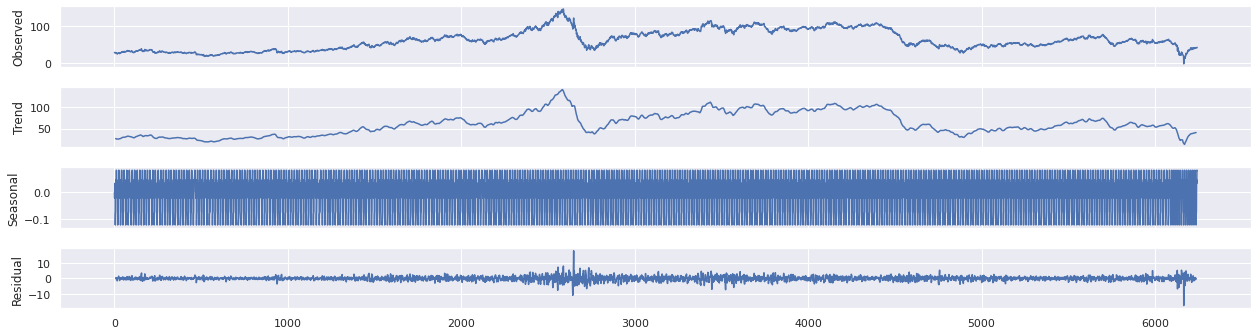

In [83]:
decomposition = sm.tsa.seasonal_decompose(oildf['Close'], freq=12)  
figure = plt.figure()  
figure = decomposition.plot()  
figure.set_size_inches(20,5)

**ADF**

In [84]:
from statsmodels.tsa.stattools import adfuller

In [85]:
result = adfuller(oildf['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('No. of lags Used: %f' % result[2])
print('No. of Observation Used: %f' % result[3])

ADF Statistic: -2.191958
p-value: 0.209177
No. of lags Used: 12.000000
No. of Observation Used: 5086.000000


In [86]:
def check_adf(time_series):
    test_result = adfuller(time_series)
    labels = ['ADF Statistic','p-value','No. of Lags Used','Number of Observations Used']
    for value,label in zip(test_result,labels):
      print (label+': '+str(value))

In [87]:
oildf['Close Oil First Difference'] = oildf['Close'] - oildf['Close'].shift(1)
check_adf(oildf['Close Oil First Difference'].dropna())

ADF Statistic: -29.145284043347917
p-value: 0.0
No. of Lags Used: 5
Number of Observations Used: 5092


**ACF and PACF**

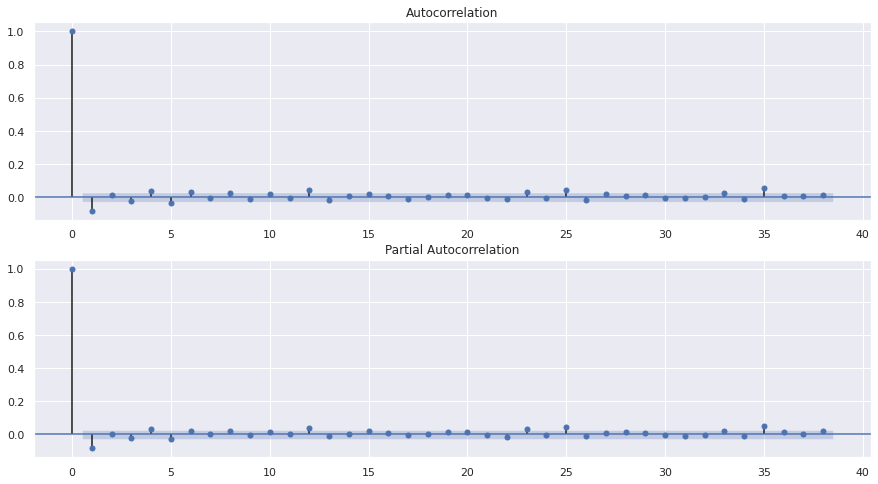

In [88]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(oildf['Close Oil First Difference'].dropna(),ax=ax1)
fig = sm.graphics.tsa.plot_pacf(oildf['Close Oil First Difference'].dropna(),ax=ax2)

In [89]:
stepwise_fit = auto_arima(oildf['Close'],trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=18411.611, Time=6.92 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18455.261, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18420.808, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18421.264, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18453.280, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18411.122, Time=3.95 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=18422.916, Time=0.78 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=18422.555, Time=3.02 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=18410.255, Time=3.71 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=18423.646, Time=1.09 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=18405.410, Time=11.09 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=18412.281, Time=11.46 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=18412.819, Time=4.01 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=18410.514, Time=4.74 sec
 ARIMA(3,1,2)(0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 5099
Model:               SARIMAX(3, 1, 4)   Log Likelihood               -9193.476
Date:                Fri, 14 May 2021   AIC                          18402.952
Time:                        10:45:18   BIC                          18455.245
Sample:                             0   HQIC                         18421.261
                               - 5099                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9108      0.040    -22.751      0.000      -0.989      -0.832
ar.L2          0.9268      0.033     28.127      0.000       0.862       0.991
ar.L3          0.8808      0.036     24.510      0.000       0.810       0.951
ma.L1          0.8277      0.041     20.211      0.000       0.747       0.908
ma.L2         -0.9805      0.034    -28.438      0.000      -1.048      -0.913
ma.L3         -0.7936      0.036    -21.947      0.000      -0.865      -0.723
ma.L4          0.0697      0.007      9.696      0.000       0.056       0.084
sigma2         2.1542      0.017    130.250      0.000       2.122       2.187
===================================================================================
Ljung-Box (Q):                       41.61   Jarque-Bera (JB):             54874.64
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               2.34   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Splitting dataset for training and testing**

In [90]:
from statsmodels.tsa.arima_model import ARIMA

In [91]:
print(oildf.shape)
train = oildf.iloc[:-30]
test=oildf.iloc[-30:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1])

(5099, 8)
(5069, 8) (30, 8)
Date                          2020-06-16
Open                               37.05
High                               39.06
Low                                36.38
Close                              37.12
Adj Close                          37.12
Volume                            339007
Close Oil First Difference      0.860001
Name: 6214, dtype: object Date                           2020-07-21
Open                                40.84
High                                 42.4
Low                                 40.84
Close                               41.76
Adj Close                           41.76
Volume                        1.32387e+06
Close Oil First Difference           1.11
Name: 6243, dtype: object


3,1,4 won't work since it gives an error that chosen AIC is not stationary even it has the lowest AIC score. Similarly with 2,1, 3 as it is the second lowest AIC. 
Third option has 4,1,3 which is the third lowest AIC score. Which seems like the 3,1,4 but reordered

In [92]:
model= ARIMA(train['Close'],order=(4,1,3))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 5068
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -9150.978
Method:                       css-mle   S.D. of innovations              1.472
Date:                Fri, 14 May 2021   AIC                          18319.956
Time:                        10:45:36   BIC                          18378.732
Sample:                             1   HQIC                         18340.542
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0020      0.025      0.082      0.935      -0.047       0.051
ar.L1.D.Close    -0.1313      0.363     -0.362      0.717      -0.843       0.580
ar.L2.D.Close     0.7858      0.055     14.360      0.000       0.679       0.893
ar.L3.D.Close     0.2197      0.315      0.698      0.485      -0.398       0.837
ar.L4.D.Close     0.0524      0.023      2.301      0.021       0.008       0.097
ma.L1.D.Close     0.0492      0.363      0.135      0.892      -0.663       0.761
ma.L2.D.Close    -0.7908      0.065    -12.135      0.000      -0.919      -0.663
ma.L3.D.Close    -0.1701      0.302     -0.563      0.573      -0.762       0.422
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0311           -0.0000j            1.0311           -0.0000
AR.2           -1.1872           -0.0000j            1.1872           -0.5000
AR.3           -2.0164           -3.3928j            3.9467           -0.3353
AR.4           -2.0164           +3.3928j            3.9467            0.3353
MA.1            1.0421           +0.0000j            1.0421            0.0000
MA.2           -1.2785           +0.0000j            1.2785            0.5000
MA.3           -4.4128           +0.0000j            4.4128            0.5000
-----------------------------------------------------------------------------
"""

**Predictions on test set**

In [93]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
pred=model.predict(start=start,end=end,typ='levels')
pred.index = oildf.index[start:end+1]
print(pred)

6214    36.361644
6215    36.310181
6216    36.414713
6217    36.418168
6218    36.494025
6219    36.507194
6220    36.571460
6221    36.590365
6222    36.645400
6223    36.667987
6224    36.715938
6225    36.740621
6226    36.783055
6227    36.808745
6228    36.846801
6229    36.872757
6230    36.907270
6231    36.932989
6232    36.964578
6233    36.989732
6234    37.018859
6235    37.043237
6236    37.070255
6237    37.093729
6238    37.118908
6239    37.141410
6240    37.164963
6241    37.186463
6242    37.208560
6243    37.229055
dtype: float64


2020-07-21 is index 6243

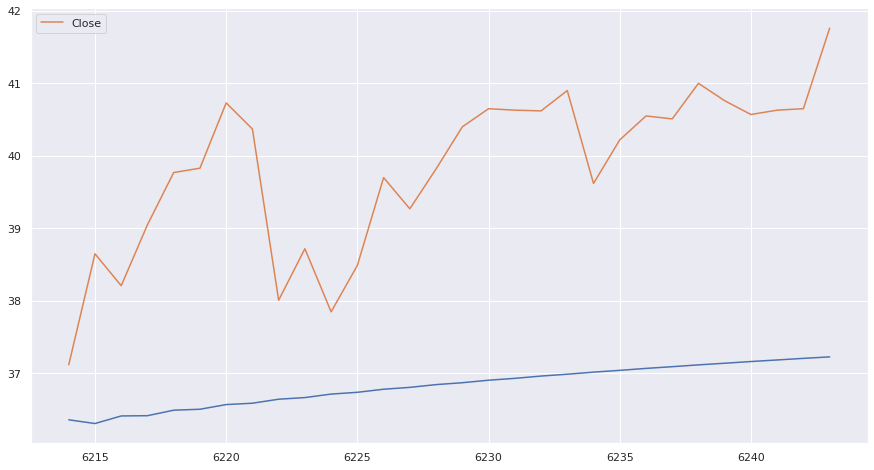

In [94]:
pred.plot(figsize = (15,8))
test['Close'].plot(legend = True)

In [95]:
test['Close'].mean()

39.8353334

In [96]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(pred, test['Close']))
print(rmse)

3.1451889734412277


root mean squared < mean value of test set. We have an average error of 3.1/39.8 * 100 = 7.8 % error

In [97]:
model7 = ARIMA(oildf['Close'],order = (4,1,3))
model7 = model7.fit()
oildf.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Close Oil First Difference
6239,2020-07-16,40.900002,41.139999,40.520000,40.759998,40.759998,77425275.0,-0.240002
6240,2020-07-17,40.740002,40.900002,40.020000,40.570000,40.570000,28236139.0,-0.189998
6241,2020-07-19,40.639999,40.650002,40.459999,40.630001,40.630001,7030.0,0.060001
6242,2020-07-20,40.360001,40.910000,39.830002,40.650002,40.650002,8747221.0,0.020001
6243,2020-07-21,40.840000,42.400002,40.840000,41.759998,41.759998,1323868.0,1.109996


In [98]:
index_future_dates = pd.date_range(start = '2020-07-21', end = '2020-08-20')
#pred.index = index_future_dates
pred = model7.predict(start = len(oildf),end=len(oildf)+30,typ = 'levels').rename('ARIMA Predictions')
#print(comp_pred)
pred.index = index_future_dates
print(pred)

2020-07-21    41.703281
2020-07-22    41.746944
2020-07-23    41.759963
2020-07-24    41.838189
2020-07-25    41.845075
2020-07-26    41.911077
2020-07-27    41.925874
2020-07-28    41.981689
2020-07-29    42.001053
2020-07-30    42.049346
2020-07-31    42.071472
2020-08-01    42.113952
2020-08-02    42.137604
2020-08-03    42.175521
2020-08-04    42.199844
2020-08-05    42.234114
2020-08-06    42.258522
2020-08-07    42.289819
2020-08-08    42.313922
2020-08-09    42.342748
2020-08-10    42.366287
2020-08-11    42.393020
2020-08-12    42.415832
2020-08-13    42.440761
2020-08-14    42.462751
2020-08-15    42.486099
2020-08-16    42.507216
2020-08-17    42.529161
2020-08-18    42.549384
2020-08-19    42.570068
2020-08-20    42.589402
Freq: D, Name: ARIMA Predictions, dtype: float64


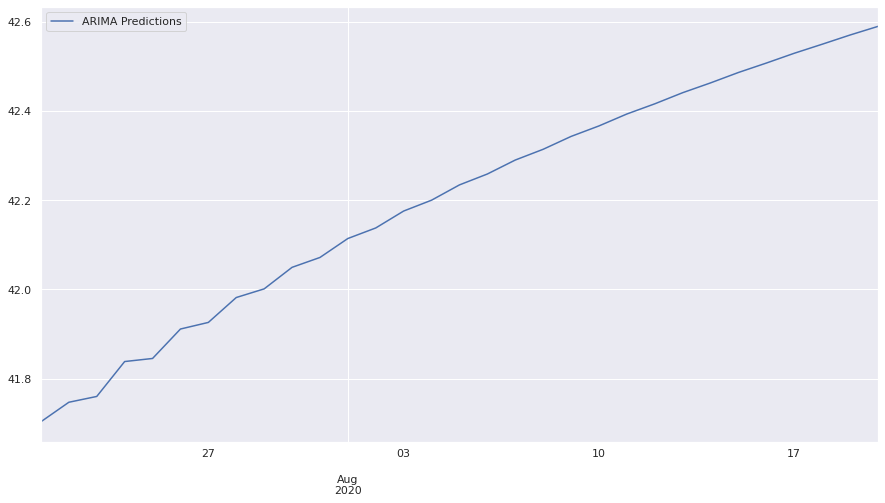

In [99]:
pred.plot(figsize = (15,8), legend = True)

**FOSSIL FUEL**

In [330]:
#Title: Ways to import CSV files in Google Colab using Pydrive
#Item type: Blog Post
#Author: GeeksforGeeks
#Availability: https://www.geeksforgeeks.org/ways-to-import-csv-files-in-google-colab/

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [331]:
link = 'https://drive.google.com/file/d/17UyI499mUj2nc6-Qp24NoS_wo-YSQHdw/view?usp=sharing'

In [332]:
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('fossilConsumption.csv')
fossildf = pd.read_csv('fossilConsumption.csv')

In [333]:
fossildf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5190 entries, 0 to 5189
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Entity                 5190 non-null   object 
 1   Code                   4145 non-null   object 
 2   Year                   5190 non-null   int64  
 3   Coal Consumption - EJ  5170 non-null   float64
 4   Gas Consumption - EJ   5170 non-null   float64
 5   Oil Consumption - EJ   5184 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 243.4+ KB


In [ ]:
#fossildf['year']=fossildf['year'].astype('datetime64[ns]')

In [334]:
fossildf.rename(columns = {'Coal Consumption - EJ':'CoalConsumption', 'Gas Consumption - EJ':'GasConsumption', 
                              'Oil Consumption - EJ':'OilConsumption','Year':'year'}, inplace = True) 

In [335]:
fossildf.drop('Code', axis='columns', inplace=True)

In [336]:
fossildf = fossildf[fossildf.Entity == 'United States']

In [337]:
fossildf.describe()

,year,CoalConsumption,GasConsumption,OilConsumption
count,55.00000,55.000000,55.000000,55.000000
mean,1992.00000,17.264495,20.957082,34.418647
std,16.02082,3.807827,3.338662,3.705079
min,1965.00000,11.340643,14.973142,23.691820
25%,1978.50000,13.706315,18.838044,32.844587
50%,1992.00000,17.518682,21.116800,34.694430
75%,2005.50000,20.508471,22.279308,36.932854
max,2019.00000,22.849045,30.479222,40.369327


In [338]:
fossildf.head()

,Entity,year,CoalConsumption,GasConsumption,OilConsumption
4880,United States,1965,11.607279,14.973142,23.691820
4881,United States,1966,12.171046,16.137922,24.875976
4882,United States,1967,11.941188,17.039478,25.837584
4883,United States,1968,12.359075,18.240534,27.630599
4884,United States,1969,12.410055,19.634785,29.135607


In [339]:
fossildf.tail()

,Entity,year,CoalConsumption,GasConsumption,OilConsumption
4930,United States,2015,15.584680,26.768862,35.660035
4931,United States,2016,14.258668,26.967562,35.917927
4932,United States,2017,13.869334,26.639711,36.285099
4933,United States,2018,13.282051,29.517910,37.107278
4934,United States,2019,11.340643,30.479222,36.988039


In [ ]:
#fossildf['year']= pd.to_datetime(fossildf['year'])

In [ ]:
#fossildf.set_index('year',inplace=True)

**Moving Average**

In [340]:
def moving_average(series,n):
  return np.average(series[-n:])
moving_average(fossildf['CoalConsumption'],12)

17.05278751769161

In [341]:
def moving_average(series,n):
  return np.average(series[-n:])
moving_average(fossildf['GasConsumption'],12)

25.708761086679885

In [342]:
def moving_average(series,n):
  return np.average(series[-n:])
moving_average(fossildf['OilConsumption'],12)

35.68619232610116

**Weighted Average**

In [343]:
def weighted_average(series, weights):
  result = 0.0
  for n in range(len(weights)):
    result += series.iloc[-n-1] * weights[n]
  return float(result)

weighted_average(fossildf['CoalConsumption'],[0.6,0.3,0.1])

12.17593457394509

In [344]:
def weighted_average(series, weights):
  result = 0.0
  for n in range(len(weights)):
    result += series.iloc[-n-1] * weights[n]
  return float(result)

weighted_average(fossildf['GasConsumption'],[0.6,0.3,0.1])

29.806877323191806

In [345]:
def weighted_average(series, weights):
  result = 0.0
  for n in range(len(weights)):
    result += series.iloc[-n-1] * weights[n]
  return float(result)

weighted_average(fossildf['OilConsumption'],[0.6,0.3,0.1])

36.95351682514631

**Time Series**

*Oil*

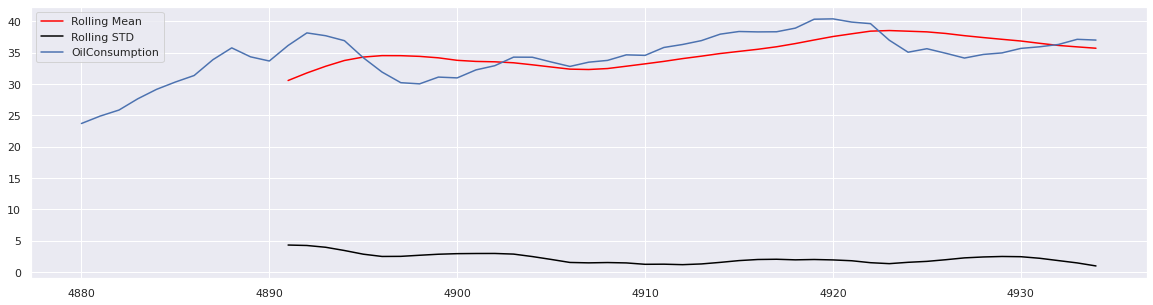

In [346]:
timeseries = fossildf['OilConsumption']
timeseries.rolling(12).mean().plot(label = 'Rolling Mean', color = 'red')
timeseries.rolling(12).std().plot(label='Rolling STD', color = 'black')
timeseries.plot(figsize = (20,5))
plt.legend()

*Gas*

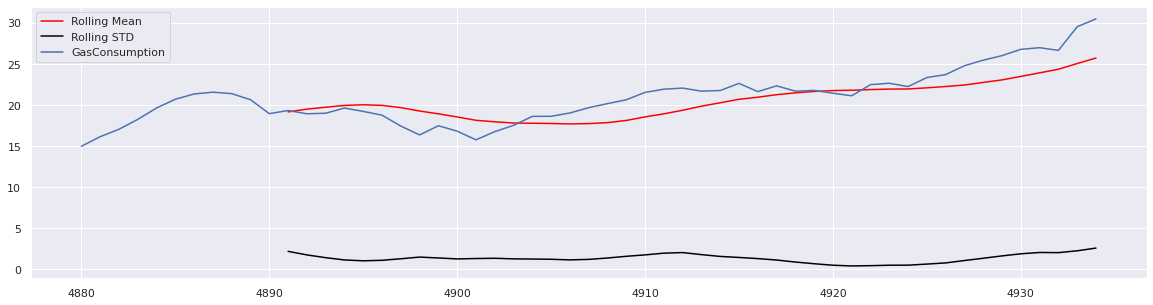

In [347]:
timeseries = fossildf['GasConsumption']
timeseries.rolling(12).mean().plot(label = 'Rolling Mean', color = 'red')
timeseries.rolling(12).std().plot(label='Rolling STD', color = 'black')
timeseries.plot(figsize = (20,5))
plt.legend()

*Coal*

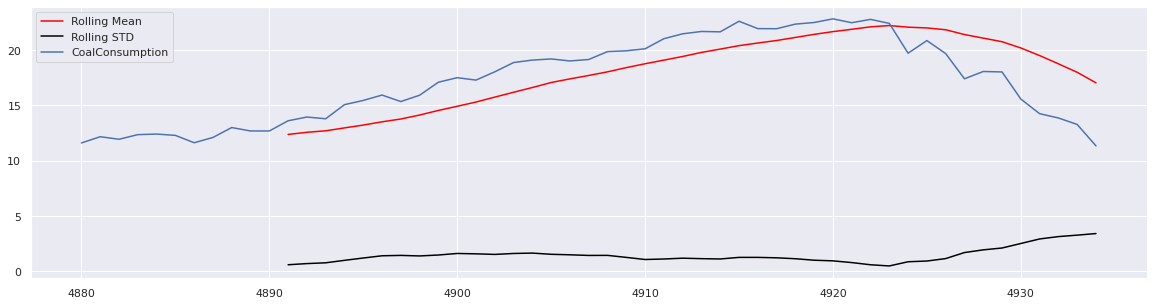

In [348]:
timeseries = fossildf['CoalConsumption']
timeseries.rolling(12).mean().plot(label = 'Rolling Mean', color = 'red')
timeseries.rolling(12).std().plot(label='Rolling STD', color = 'black')
timeseries.plot(figsize = (20,5))
plt.legend()

**Decomposition**

*Oil*

<Figure size 432x288 with 0 Axes>

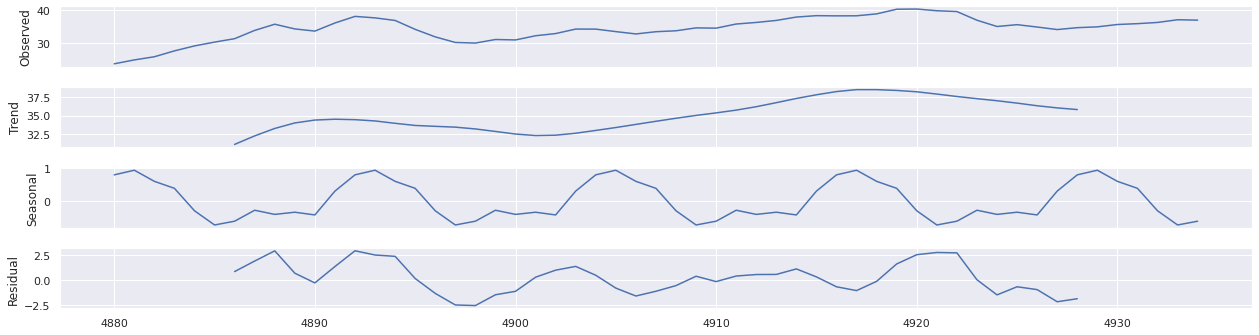

In [349]:
decomposition = sm.tsa.seasonal_decompose(fossildf['OilConsumption'], freq=12)  
figure = plt.figure()  
figure = decomposition.plot()  
figure.set_size_inches(20,5)

*Gas*

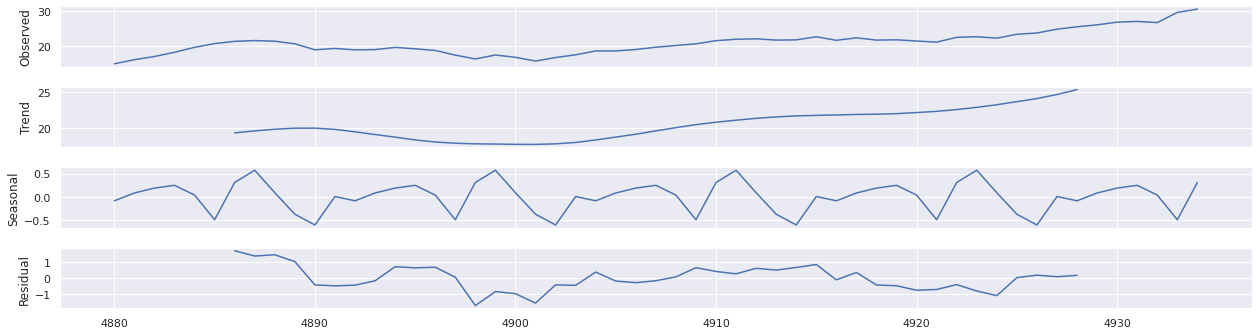

In [350]:
decomposition = sm.tsa.seasonal_decompose(fossildf['GasConsumption'], freq=12)  
#figure = plt.figure()  
figure = decomposition.plot()  
figure.set_size_inches(20,5)

*Coal*

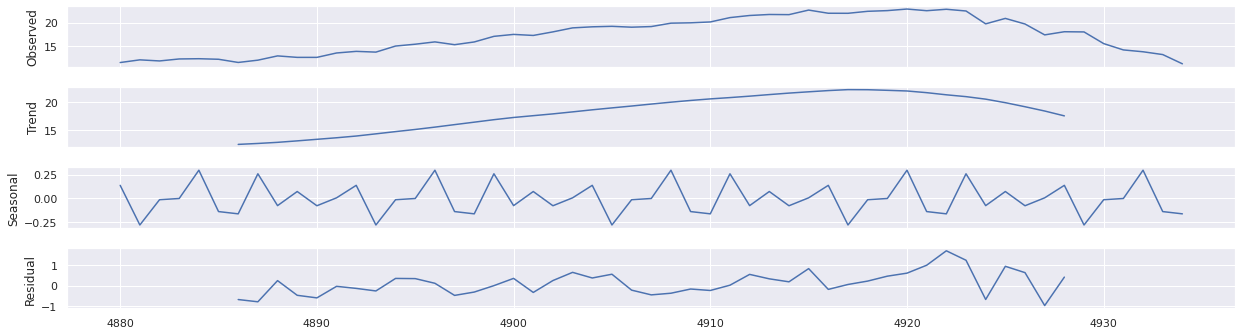

In [351]:
decomposition = sm.tsa.seasonal_decompose(fossildf['CoalConsumption'], freq=12)  
#figure = plt.figure()  
figure = decomposition.plot()  
figure.set_size_inches(20,5)

**ADF**

In [352]:
from statsmodels.tsa.stattools import adfuller

*Oil*

In [353]:
result = adfuller(fossildf['OilConsumption'])
print ('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('No. of lags Used: %f' % result[2])
print('No. of Observation Used: %f' % result[3])

ADF Statistic: -3.071120
p-value: 0.028766
No. of lags Used: 1.000000
No. of Observation Used: 53.000000


*Gas*

In [354]:
result = adfuller(fossildf['GasConsumption'])
print ('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('No. of lags Used: %f' % result[2])
print('No. of Observation Used: %f' % result[3])

ADF Statistic: 0.531837
p-value: 0.985809
No. of lags Used: 0.000000
No. of Observation Used: 54.000000


In [355]:
fossildf['Gas First Difference'] = fossildf['GasConsumption'] - fossildf['GasConsumption'].shift(1)
check_adf(fossildf['Gas First Difference'].dropna())

ADF Statistic: -5.84569846998224
p-value: 3.6881456181768157e-07
No. of Lags Used: 0
Number of Observations Used: 53


*Coal*

In [356]:
result = adfuller(fossildf['CoalConsumption'])
print ('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('No. of lags Used: %f' % result[2])
print('No. of Observation Used: %f' % result[3])

ADF Statistic: -2.460668
p-value: 0.125340
No. of lags Used: 8.000000
No. of Observation Used: 46.000000


In [357]:
fossildf['Coal First Difference'] = fossildf['CoalConsumption'] - fossildf['CoalConsumption'].shift(8)
check_adf(fossildf['Coal First Difference'].dropna())

ADF Statistic: -1.2937328835009072
p-value: 0.6320346272916493
No. of Lags Used: 7
Number of Observations Used: 39


From further differencing p value still remains > than 0.05, 0.1 still remains the smallest result in p value

**ACF and PACF**

*Oil*

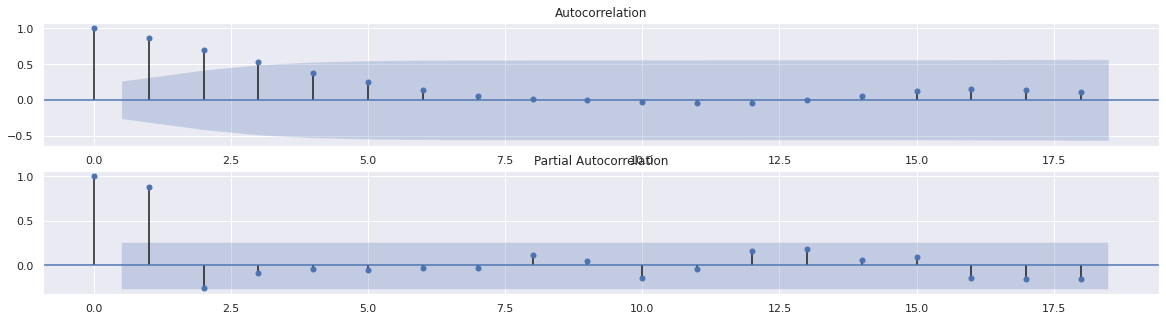

In [360]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(fossildf['OilConsumption'].dropna(),ax=ax1)
fig = sm.graphics.tsa.plot_pacf(fossildf['OilConsumption'].dropna(),ax=ax2)

*Gas*

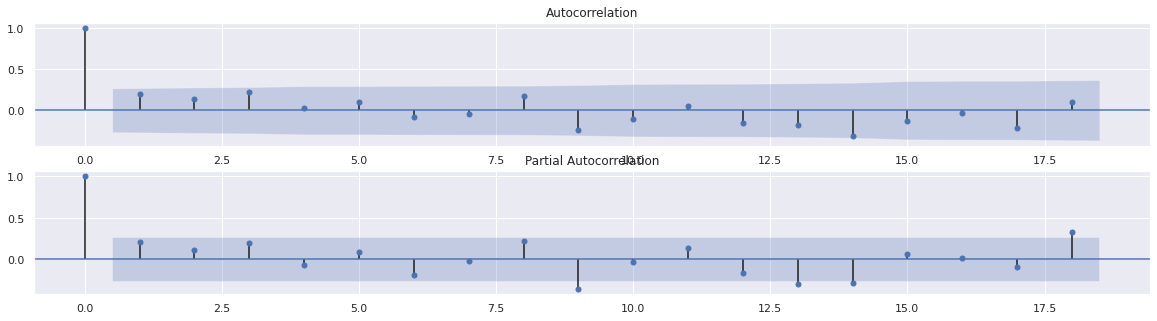

In [361]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(fossildf['Gas First Difference'].dropna(),ax=ax1)
fig = sm.graphics.tsa.plot_pacf(fossildf['Gas First Difference'].dropna(),ax=ax2)

*Coal*

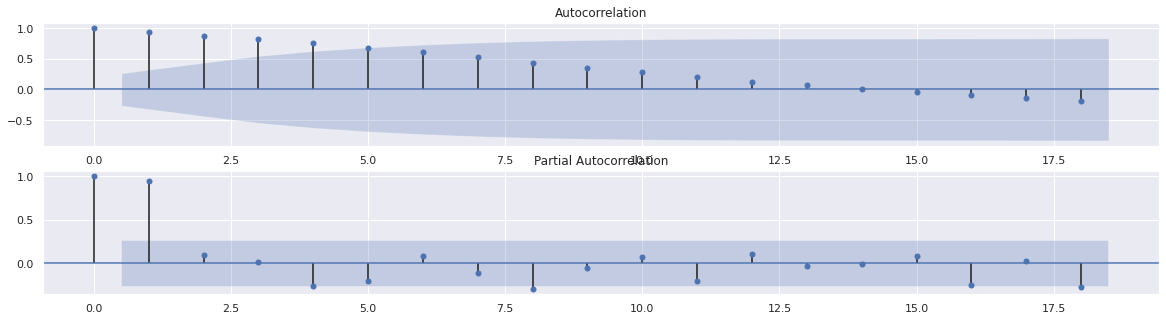

In [362]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(fossildf['CoalConsumption'].dropna(),ax=ax1)
fig = sm.graphics.tsa.plot_pacf(fossildf['CoalConsumption'].dropna(),ax=ax2)

**Pmd Library**

*Oil*

In [363]:
stepwise_fit = auto_arima(fossildf['OilConsumption'],trace=True,suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=164.511, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=173.742, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=160.794, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=159.230, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=174.102, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=160.568, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=160.610, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=162.512, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=158.641, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=159.670, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=159.777, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=159.684, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=161.528, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.672 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   55
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -77.321
Date:                Fri, 14 May 2021   AIC                            158.641
Time:                        11:10:25   BIC                            162.619
Sample:                             0   HQIC                           160.176
                                 - 55                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5500      0.150      3.667      0.000       0.256       0.844
sigma2         1.0194      0.185      5.514      0.000       0.657       1.382
===================================================================================
Ljung-Box (Q):                       32.00   Jarque-Bera (JB):                 2.47
Prob(Q):                              0.81   Prob(JB):                         0.29
Heteroskedasticity (H):               0.43   Skew:                            -0.44
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

*Gas*

In [364]:
stepwise_fit = auto_arima(fossildf['GasConsumption'],trace=True,suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=139.001, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=135.298, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=135.058, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=135.419, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=139.601, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=136.135, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=135.288, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=137.083, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=137.179, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.503 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   55
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 -64.529
Date:                Fri, 14 May 2021   AIC                            135.058
Time:                        11:10:30   BIC                            141.025
Sample:                             0   HQIC                           137.359
                                 - 55                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2346      0.111      2.116      0.034       0.017       0.452
ar.L1          0.2033      0.156      1.306      0.191      -0.102       0.508
sigma2         0.6385      0.102      6.229      0.000       0.438       0.839
===================================================================================
Ljung-Box (Q):                       71.50   Jarque-Bera (JB):                 3.34
Prob(Q):                              0.00   Prob(JB):                         0.19
Heteroskedasticity (H):               1.12   Skew:                             0.33
Prob(H) (two-sided):                  0.81   Kurtosis:                         4.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

*Coal*

In [365]:
stepwise_fit = auto_arima(fossildf['CoalConsumption'],trace=True,suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=116.828, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=165.212, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=156.919, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=132.453, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=135.341, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=115.442, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=132.366, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=123.619, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=116.782, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=116.389, Time=0.04 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=118.745, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=115.793, Time=0.09 sec

Best model:  ARIMA(2,2,1)(0,0,0)[0]          
Total fit time: 0.660 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   55
Model:               SARIMAX(2, 2, 1)   Log Likelihood                 -53.721
Date:                Fri, 14 May 2021   AIC                            115.442
Time:                        11:10:34   BIC                            123.323
Sample:                             0   HQIC                           118.472
                                 - 55                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5142      0.118     -4.355      0.000      -0.746      -0.283
ar.L2         -0.6163      0.122     -5.041      0.000      -0.856      -0.377
ma.L1         -0.5400      0.135     -3.990      0.000      -0.805      -0.275
sigma2         0.4268      0.056      7.583      0.000       0.316       0.537
===================================================================================
Ljung-Box (Q):                       25.58   Jarque-Bera (JB):                30.39
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.72   Skew:                            -1.27
Prob(H) (two-sided):                  0.04   Kurtosis:                         5.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Splitting dataset for training and testing**

In [366]:
print(fossildf.shape)
train = fossildf.iloc[:-30]
test=fossildf.iloc[-30:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1])

(55, 7)
(25, 7) (30, 7)
Entity                   United States
year                              1990
CoalConsumption                19.2168
GasConsumption                 18.6142
OilConsumption                 33.4972
Gas First Difference        0.00139964
Coal First Difference          3.85992
Name: 4905, dtype: object Entity                   United States
year                              2019
CoalConsumption                11.3406
GasConsumption                 30.4792
OilConsumption                  36.988
Gas First Difference          0.961311
Coal First Difference         -8.36241
Name: 4934, dtype: object


same output for oil, coal and gas

*Oil*

In [367]:
model4= ARIMA(train['OilConsumption'],order=(0,1,1))
model4 = model4.fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.OilConsumption   No. Observations:                   24
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -38.268
Method:                       css-mle   S.D. of innovations              1.180
Date:                Fri, 14 May 2021   AIC                             82.536
Time:                        11:10:42   BIC                             86.070
Sample:                             1   HQIC                            83.474
                                                                              
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.4278      0.385      1.111      0.278      -0.327       1.182
ma.L1.D.OilConsumption     0.6230      0.194      3.217      0.004       0.243       1.003
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.6052           +0.0000j            1.6052            0.5000
-----------------------------------------------------------------------------
"""

*Gas*

In [368]:
model5= ARIMA(train['GasConsumption'],order=(1,1,0))
model5 = model5.fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.GasConsumption   No. Observations:                   24
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -29.428
Method:                       css-mle   S.D. of innovations              0.821
Date:                Fri, 14 May 2021   AIC                             64.856
Time:                        11:10:45   BIC                             68.390
Sample:                             1   HQIC                            65.793
                                                                              
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.2076      0.284      0.730      0.473      -0.349       0.765
ar.L1.D.GasConsumption     0.4212      0.190      2.219      0.037       0.049       0.793
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3743           +0.0000j            2.3743            0.0000
-----------------------------------------------------------------------------
"""

*Coal*

In [369]:
model6= ARIMA(train['CoalConsumption'],order=(2,2,1))
model6 = model6.fit()
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:     D2.CoalConsumption   No. Observations:                   23
Model:                 ARIMA(2, 2, 1)   Log Likelihood                 -14.573
Method:                       css-mle   S.D. of innovations              0.409
Date:                Fri, 14 May 2021   AIC                             39.147
Time:                        11:10:47   BIC                             44.824
Sample:                             2   HQIC                            40.575
                                                                              
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0213      0.007      2.916      0.009       0.007       0.036
ar.L1.D2.CoalConsumption    -0.2919      0.176     -1.659      0.113      -0.637       0.053
ar.L2.D2.CoalConsumption    -0.5327      0.167     -3.181      0.005      -0.861      -0.204
ma.L1.D2.CoalConsumption    -1.0000      0.134     -7.453      0.000      -1.263      -0.737
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2740           -1.3425j            1.3702           -0.2820
AR.2           -0.2740           +1.3425j            1.3702            0.2820
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

**Predictions on Test Set**

In [370]:
start=len(train)
end=len(train)+len(test)-1
pred=model4.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
pred=model4.predict(start=start,end=end,typ='levels')
pred.index = fossildf.index[start:end+1]
print(pred)

4905    33.891806
4906    34.319636
4907    34.747466
4908    35.175296
4909    35.603126
4910    36.030956
4911    36.458786
4912    36.886616
4913    37.314446
4914    37.742276
4915    38.170106
4916    38.597936
4917    39.025766
4918    39.453596
4919    39.881426
4920    40.309256
4921    40.737086
4922    41.164916
4923    41.592746
4924    42.020576
4925    42.448405
4926    42.876235
4927    43.304065
4928    43.731895
4929    44.159725
4930    44.587555
4931    45.015385
4932    45.443215
4933    45.871045
4934    46.298875
dtype: float64


In [371]:
start=len(train)
end=len(train)+len(test)-1
pred=model5.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
pred=model5.predict(start=start,end=end,typ='levels')
pred.index = fossildf.index[start:end+1]
print(pred)

4905    19.194191
4906    19.559219
4907    19.833116
4908    20.068630
4909    20.287977
4910    20.500515
4911    20.710185
4912    20.918647
4913    21.126600
4914    21.334339
4915    21.541988
4916    21.749599
4917    21.957194
4918    22.164782
4919    22.372368
4920    22.579952
4921    22.787535
4922    22.995119
4923    23.202702
4924    23.410286
4925    23.617869
4926    23.825452
4927    24.033035
4928    24.240619
4929    24.448202
4930    24.655785
4931    24.863368
4932    25.070952
4933    25.278535
4934    25.486118
dtype: float64


In [372]:
start=len(train)
end=len(train)+len(test)-1
pred=model6.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
pred=model6.predict(start=start,end=end,typ='levels')
pred.index = fossildf.index[start:end+1]
print(pred)

4905    19.628778
4906    20.425819
4907    21.024392
4908    21.569622
4909    22.275042
4910    23.001019
4911    23.674574
4912    24.391385
4913    25.162396
4914    25.933449
4915    26.714524
4916    27.531555
4917    28.371656
4918    29.224774
4919    30.100708
4920    31.001952
4921    31.922559
4922    32.862937
4923    33.826133
4924    34.811041
4925    35.816361
4926    36.843061
4927    37.891552
4928    38.961198
4929    40.051965
4930    41.164203
4931    42.297827
4932    43.452675
4933    44.628841
4934    45.826382
dtype: float64


*Oil*

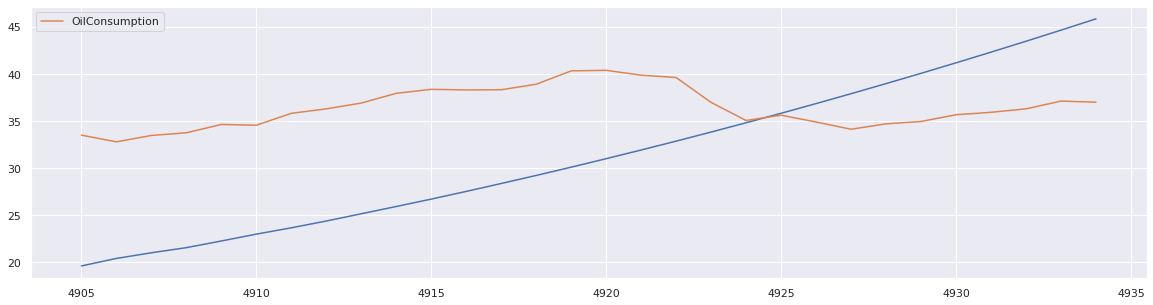

In [373]:
pred.plot(figsize = (20,5))
test['OilConsumption'].plot(legend = True)

*Gas*

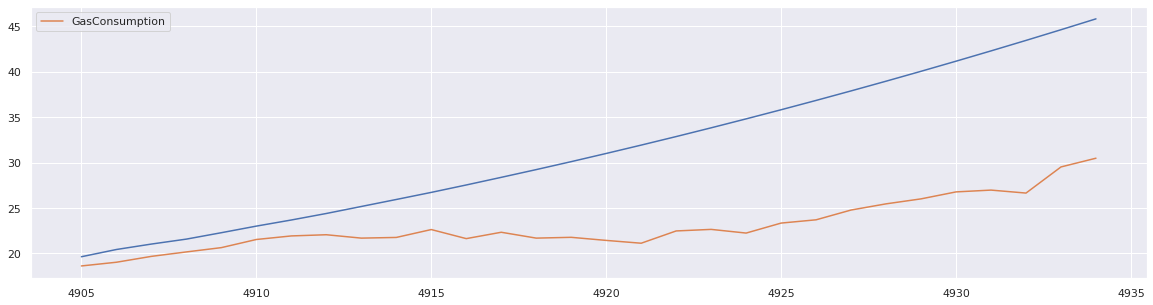

In [374]:
pred.plot(figsize = (20,5))
test['GasConsumption'].plot(legend = True)

*Coal*

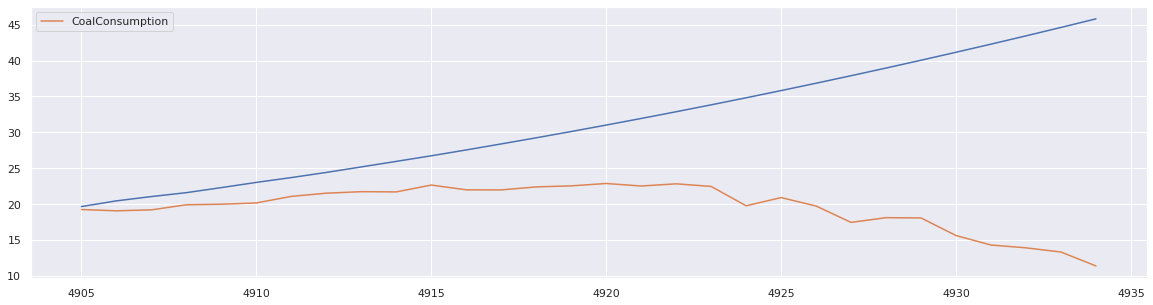

In [375]:
pred.plot(figsize = (20,5))
test['CoalConsumption'].plot(legend = True)

In [376]:
test['OilConsumption'].mean()

36.39417337382769

In [377]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(pred, test['OilConsumption']))
print(rmse)

9.269803151771471


root mean squared < mean value of test set. We have an average error of 9.3 / 36.4 = 25.5%

In [378]:
test['GasConsumption'].mean()

23.01861500748991

In [379]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(pred, test['GasConsumption']))
print(rmse)

9.88889452313988


root mean squared < mean value of test set. We have an average error of 9.9 / 23 * 100 = 43%

In [380]:
test['CoalConsumption'].mean()

19.58456926500457

In [381]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(pred, test['CoalConsumption']))
print(rmse)

15.511515463588845


root mean squared < mean value of test set. We have an average error of 15.5 / 19.6 * 100 = 79%

**Future Dates**

*Oil*

In [382]:
model4 = ARIMA(fossildf['OilConsumption'],order = (0,1,1))
model4 = model4.fit()
fossildf.tail()

,Entity,year,CoalConsumption,GasConsumption,OilConsumption,Gas First Difference,Coal First Difference
4930,United States,2015,15.584680,26.768862,35.660035,0.767485,-7.217179
4931,United States,2016,14.258668,26.967562,35.917927,0.198700,-8.180328
4932,United States,2017,13.869334,26.639711,36.285099,-0.327851,-5.867222
4933,United States,2018,13.282051,29.517910,37.107278,2.878200,-7.599899
4934,United States,2019,11.340643,30.479222,36.988039,0.961311,-8.362414


In [383]:
index_future_dates = pd.date_range(start = '2019', end = '2020')
pred = model4.predict(start = len(fossildf),end=len(fossildf)+30,typ = 'levels').rename('ARIMA Predictions')
#pred.index = index_future_dates
print(pred)

54    36.915935
55    37.164969
56    37.414002
57    37.663036
58    37.912069
59    38.161102
60    38.410136
61    38.659169
62    38.908203
63    39.157236
64    39.406269
65    39.655303
66    39.904336
67    40.153370
68    40.402403
69    40.651437
70    40.900470
71    41.149503
72    41.398537
73    41.647570
74    41.896604
75    42.145637
76    42.394670
77    42.643704
78    42.892737
79    43.141771
80    43.390804
81    43.639837
82    43.888871
83    44.137904
84    44.386938
Name: ARIMA Predictions, dtype: float64


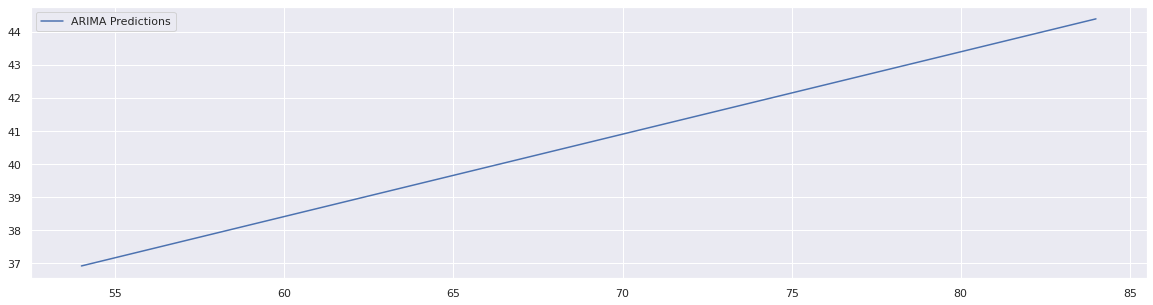

In [384]:
pred.plot(figsize = (20,5),legend = True)

*Gas*

In [385]:
model5 = ARIMA(fossildf['GasConsumption'],order = (1,1,0))
model5 = model5.fit()
fossildf.tail()

,Entity,year,CoalConsumption,GasConsumption,OilConsumption,Gas First Difference,Coal First Difference
4930,United States,2015,15.584680,26.768862,35.660035,0.767485,-7.217179
4931,United States,2016,14.258668,26.967562,35.917927,0.198700,-8.180328
4932,United States,2017,13.869334,26.639711,36.285099,-0.327851,-5.867222
4933,United States,2018,13.282051,29.517910,37.107278,2.878200,-7.599899
4934,United States,2019,11.340643,30.479222,36.988039,0.961311,-8.362414


In [386]:
index_future_dates = pd.date_range(start = '2019', end = '2020')
pred = model5.predict(start = len(fossildf),end=len(fossildf)+30,typ = 'levels').rename('ARIMA Predictions')
#pred.index = index_future_dates
print(pred)

54    30.909177
55    31.231137
56    31.531147
57    31.826697
58    32.121340
59    32.415798
60    32.710219
61    33.004633
62    33.299045
63    33.593456
64    33.887868
65    34.182279
66    34.476691
67    34.771102
68    35.065514
69    35.359925
70    35.654337
71    35.948748
72    36.243160
73    36.537571
74    36.831983
75    37.126394
76    37.420806
77    37.715217
78    38.009629
79    38.304040
80    38.598452
81    38.892863
82    39.187275
83    39.481686
84    39.776098
Name: ARIMA Predictions, dtype: float64


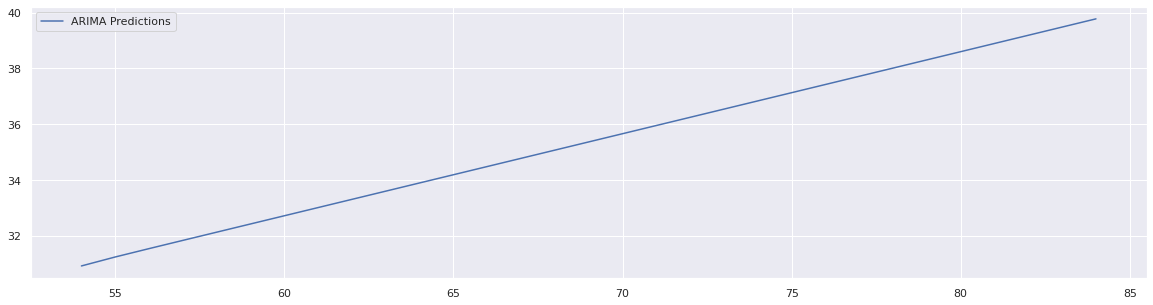

In [388]:
pred.plot(figsize = (20,5),legend = True)

*Coal*

In [389]:
model6 = ARIMA(fossildf['CoalConsumption'],order = (2,2,1))
model6 = model6.fit()
fossildf.tail()

,Entity,year,CoalConsumption,GasConsumption,OilConsumption,Gas First Difference,Coal First Difference
4930,United States,2015,15.584680,26.768862,35.660035,0.767485,-7.217179
4931,United States,2016,14.258668,26.967562,35.917927,0.198700,-8.180328
4932,United States,2017,13.869334,26.639711,36.285099,-0.327851,-5.867222
4933,United States,2018,13.282051,29.517910,37.107278,2.878200,-7.599899
4934,United States,2019,11.340643,30.479222,36.988039,0.961311,-8.362414


In [390]:
index_future_dates = pd.date_range(start = '2019', end = '2020')
pred = model6.predict(start = len(fossildf),end=len(fossildf)+30,typ = 'levels').rename('ARIMA Predictions')
#pred.index = index_future_dates
print(pred)

53    10.364980
54     9.679979
55     8.206470
56     6.899556
57     5.939083
58     4.650693
59     3.263322
60     2.074239
61     0.794075
62    -0.613508
63    -1.953318
64    -3.301233
65    -4.738465
66    -6.177807
67    -7.613430
68    -9.101583
69   -10.617564
70   -12.139393
71   -13.693221
72   -15.279343
73   -16.881624
74   -18.507990
75   -20.164325
76   -21.842824
77   -23.543813
78   -25.271900
79   -27.024570
80   -28.800269
81   -30.601316
82   -32.427496
83   -34.277499
Name: ARIMA Predictions, dtype: float64


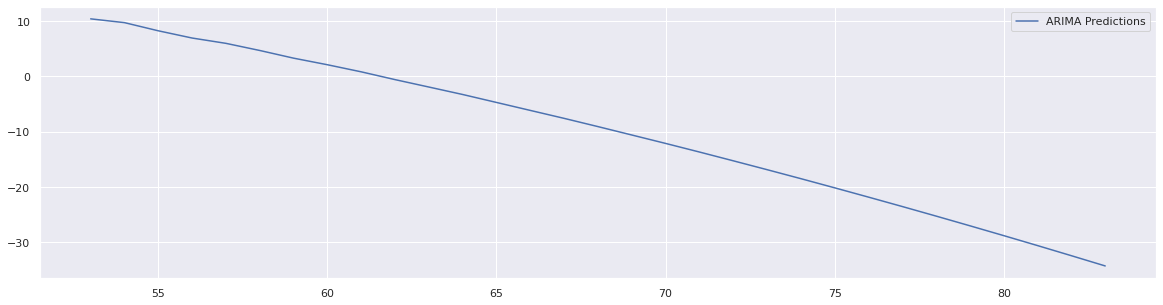

In [391]:
pred.plot(figsize = (20,5),legend = True)

**CO2**

In [392]:
#Title: Ways to import CSV files in Google Colab using Pydrive
#Item type: Blog Post
#Author: GeeksforGeeks
#Availability: https://www.geeksforgeeks.org/ways-to-import-csv-files-in-google-colab/

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [393]:
link = 'https://drive.google.com/file/d/1vZGR58aOIt4b58EyFFzqf2SdH0XVFLw-/view?usp=sharing'

In [394]:
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('carbonemissions.csv')
carbondf = pd.read_csv('carbonemissions.csv')

In [395]:
from google.colab import files
carbondf.to_csv('carbonemissions.csv') 

In [396]:
carbondf.drop(['iso_code','co2_growth_abs','consumption_co2','trade_co2','trade_co2_share','co2_per_capita','consumption_co2_per_capita','cumulative_co2','share_global_cumulative_co2','consumption_co2_per_gdp','co2_growth_prct','co2_per_unit_energy','cement_co2','coal_co2','flaring_co2','gas_co2','oil_co2','cement_co2_per_capita','coal_co2_per_capita','flaring_co2_per_capita','gas_co2_per_capita','oil_co2_per_capita','total_ghg','ghg_per_capita','methane','methane_per_capita','nitrous_oxide','nitrous_oxide_per_capita','primary_energy_consumption','energy_per_capita','energy_per_gdp','population','gdp'], axis=1, inplace=True)

In [397]:
carbondf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24016 entries, 0 to 24015
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   country           24016 non-null  object 
 1   year              24016 non-null  int64  
 2   co2               23372 non-null  float64
 3   share_global_co2  23372 non-null  float64
 4   co2_per_gdp       14949 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 938.2+ KB


In [398]:
carbondf.head()

,country,year,co2,share_global_co2,co2_per_gdp
0,Afghanistan,1949,0.015,0.000,NaN
1,Afghanistan,1950,0.084,0.001,0.004
2,Afghanistan,1951,0.092,0.001,0.005
3,Afghanistan,1952,0.092,0.001,0.004
4,Afghanistan,1953,0.106,0.002,0.005


In [399]:
carbondf.tail()

,country,year,co2,share_global_co2,co2_per_gdp
24011,Zimbabwe,2014,11.962,0.034,0.483
24012,Zimbabwe,2015,12.163,0.034,0.486
24013,Zimbabwe,2016,10.807,0.030,0.430
24014,Zimbabwe,2017,12.026,0.033,NaN
24015,Zimbabwe,2018,12.263,0.034,NaN


In [400]:
carbondf = carbondf[carbondf.country == 'United States']

In [ ]:
#carbondf.set_index('year',inplace=True)

**Moving Average**

In [401]:
def moving_average(series,n):
  return np.average(series[-n:])
moving_average(carbondf['co2'],12)

5558.8192500000005

In [402]:
def moving_average(series,n):
  return np.average(series[-n:])
moving_average(carbondf['share_global_co2'],12)

16.30375

In [403]:
def moving_average(series,n):
  return np.average(series[-n:])
moving_average(carbondf['co2_per_gdp'],12)

nan

**Weighted Average**

In [404]:
def weighted_average(series, weights):
  result = 0.0
  for n in range(len(weights)):
    result += series.iloc[-n-1] * weights[n]
  return float(result)

weighted_average(carbondf['co2'],[0.6,0.3,0.1])

5361.6577

In [405]:
def weighted_average(series, weights):
  result = 0.0
  for n in range(len(weights)):
    result += series.iloc[-n-1] * weights[n]
  return float(result)

weighted_average(carbondf['share_global_co2'],[0.6,0.3,0.1])

14.7472

In [406]:
def weighted_average(series, weights):
  result = 0.0
  for n in range(len(weights)):
    result += series.iloc[-n-1] * weights[n]
  return float(result)

weighted_average(carbondf['co2_per_gdp'],[0.6,0.3,0.1])

nan

**Time Series**

*CO2*

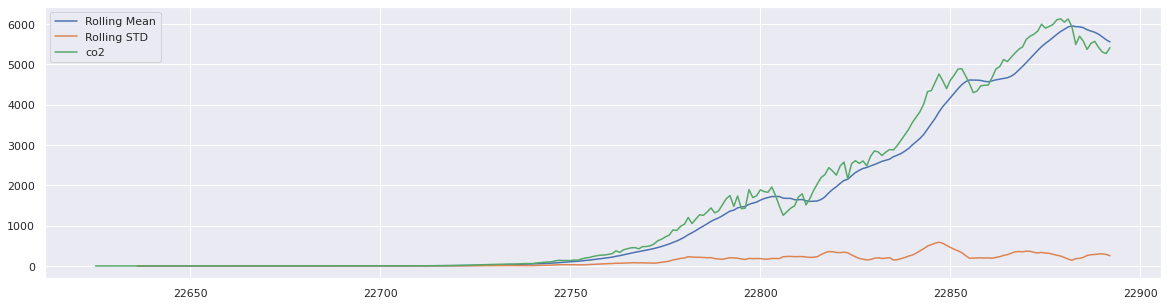

In [407]:
timeseries = carbondf['co2']
timeseries.rolling(12).mean().plot(label = 'Rolling Mean')
timeseries.rolling(12).std().plot(label='Rolling STD')
timeseries.plot(figsize = (20,5))
plt.legend()

*Share Global*

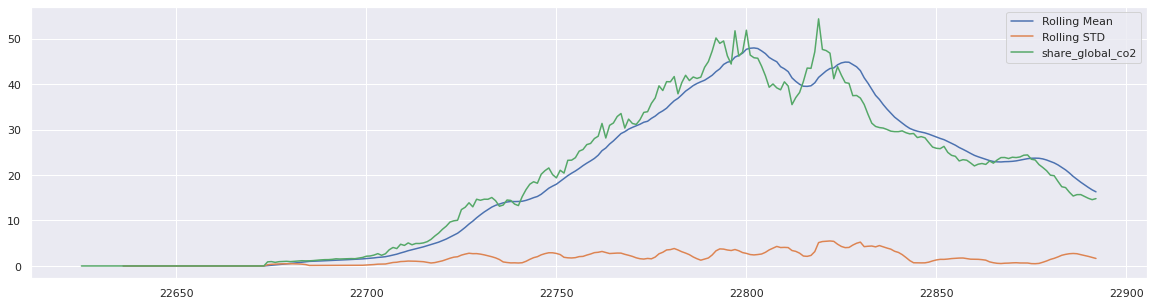

In [408]:
timeseries = carbondf['share_global_co2']
timeseries.rolling(12).mean().plot(label = 'Rolling Mean')
timeseries.rolling(12).std().plot(label='Rolling STD')
timeseries.plot(figsize = (20,5))
plt.legend()

*CO2 per GDP*

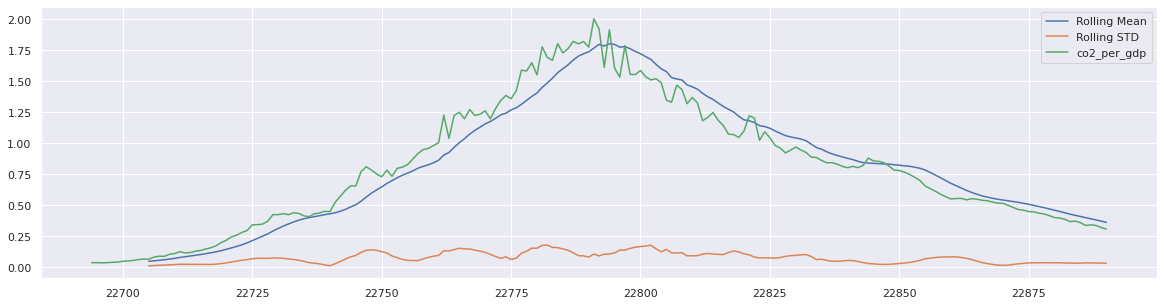

In [409]:
timeseries = carbondf['co2_per_gdp']
timeseries.rolling(12).mean().plot(label = 'Rolling Mean')
timeseries.rolling(12).std().plot(label='Rolling STD')
timeseries.plot(figsize = (20,5))
plt.legend()

**Decomposition**

*CO2*

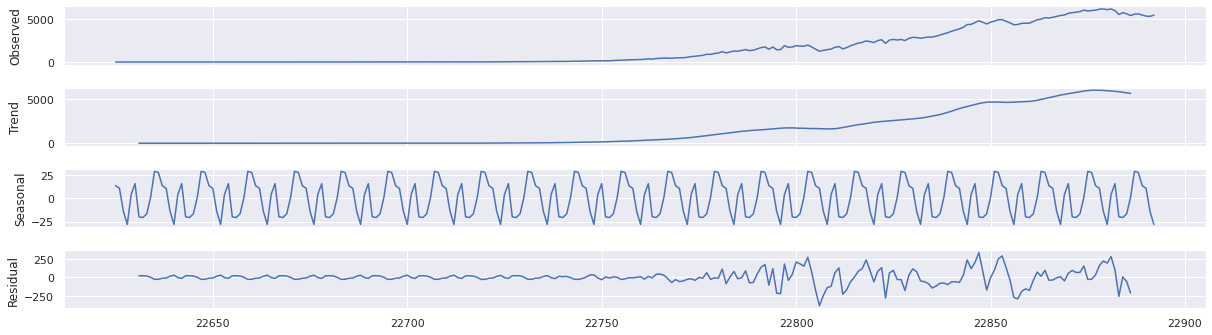

In [410]:
decomposition = sm.tsa.seasonal_decompose(carbondf['co2'], freq=12)  
#figure = plt.figure()  
figure = decomposition.plot()  
figure.set_size_inches(20,5)

*Share Global*

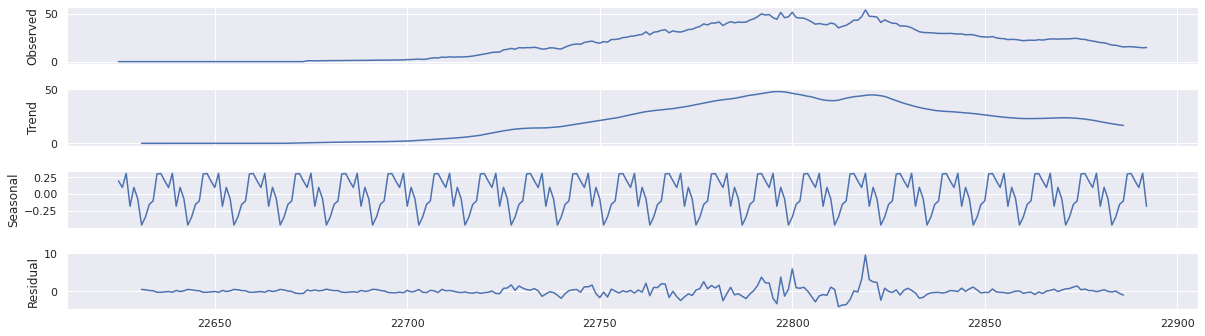

In [411]:
decomposition = sm.tsa.seasonal_decompose(carbondf['share_global_co2'], freq=12)  
#figure = plt.figure()  
figure = decomposition.plot()  
figure.set_size_inches(20,5)

*CO2 per gdp*
*   Replacing NaN values for one column since decomposition is returning error for inf or missing values


In [412]:
carbondf['co2_per_gdp'] = carbondf['co2_per_gdp'].fillna(0)

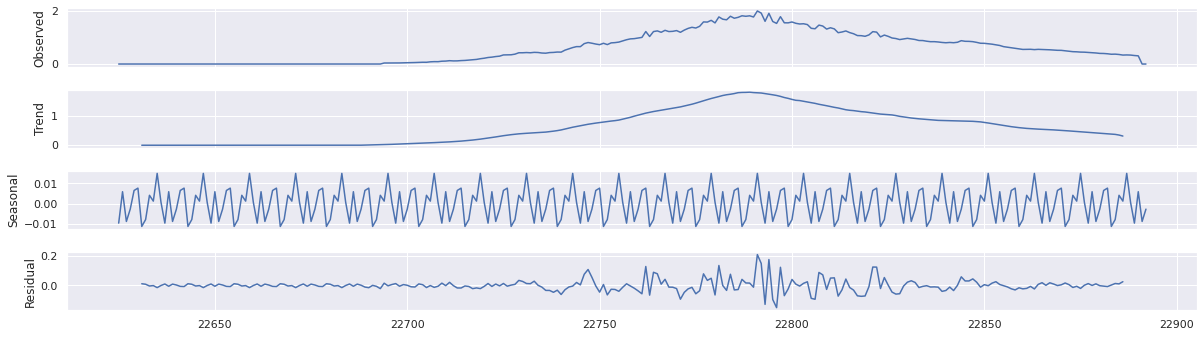

In [413]:
decomposition = sm.tsa.seasonal_decompose(carbondf['co2_per_gdp'], freq=12)  
#figure = plt.figure()  
figure = decomposition.plot()  
figure.set_size_inches(20,5)

**ADF**

*CO2*

In [414]:
result = adfuller(carbondf['co2'])
print ('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('No. of lags Used: %f' % result[2])
print('No. of Observation Used: %f' % result[3])

ADF Statistic: 1.055772
p-value: 0.994821
No. of lags Used: 12.000000
No. of Observation Used: 255.000000


In [415]:
def check_adf(time_series):
    test_result = adfuller(time_series)
    labels = ['ADF Statistic','p-value','No. of Lags Used','Number of Observations Used']
    for value,label in zip(test_result,labels):
      print (label+': '+str(value))

In [416]:
carbondf['co2 First Difference'] = carbondf['co2'] - carbondf['co2'].shift(1)
check_adf(carbondf['co2 First Difference'].dropna())

ADF Statistic: -4.191398859652929
p-value: 0.000681341138046258
No. of Lags Used: 11
Number of Observations Used: 255


*Share Global*

In [417]:
result = adfuller(carbondf['share_global_co2'])
print ('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('No. of lags Used: %f' % result[2])
print('No. of Observation Used: %f' % result[3])

ADF Statistic: -1.280451
p-value: 0.638068
No. of lags Used: 3.000000
No. of Observation Used: 264.000000


In [418]:
carbondf['Global First Difference'] = carbondf['share_global_co2'] - carbondf['share_global_co2'].shift(1)
check_adf(carbondf['Global First Difference'].dropna())

ADF Statistic: -6.697990838443882
p-value: 3.954668787118804e-09
No. of Lags Used: 2
Number of Observations Used: 264


*CO2 Per GDP*

In [419]:
result = adfuller(carbondf['co2_per_gdp'])
print ('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('No. of lags Used: %f' % result[2])
print('No. of Observation Used: %f' % result[3])

ADF Statistic: -1.091416
p-value: 0.718483
No. of lags Used: 11.000000
No. of Observation Used: 256.000000


In [420]:
def check_adf(time_series):
    test_result = adfuller(time_series)
    labels = ['ADF Statistic','p-value','No. of Lags Used','Number of Observations Used']
    for value,label in zip(test_result,labels):
      print (label+': '+str(value))

In [421]:
carbondf['GDP First Difference'] = carbondf['co2_per_gdp'] - carbondf['co2_per_gdp'].shift(1)
check_adf(carbondf['GDP First Difference'].dropna())

ADF Statistic: -2.0825133514386
p-value: 0.2516039536230874
No. of Lags Used: 10
Number of Observations Used: 256


**ACF and PACF**

*CO2*

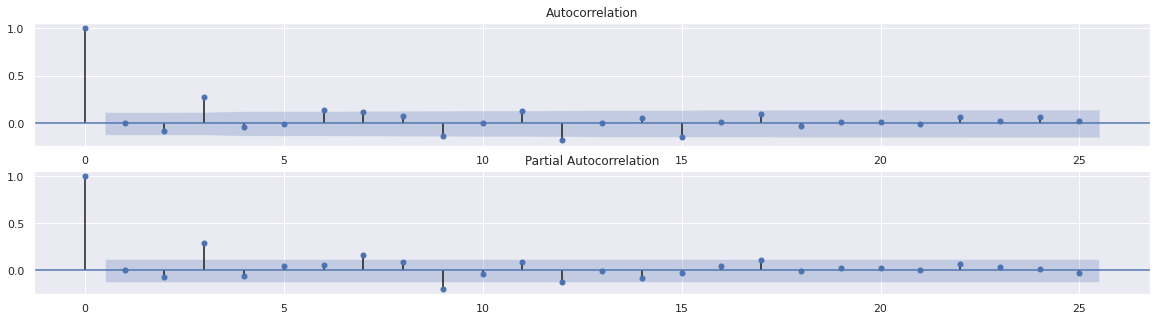

In [422]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(carbondf['co2 First Difference'].dropna(),ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(carbondf['co2 First Difference'].dropna(),ax=ax2)

*Share Global*

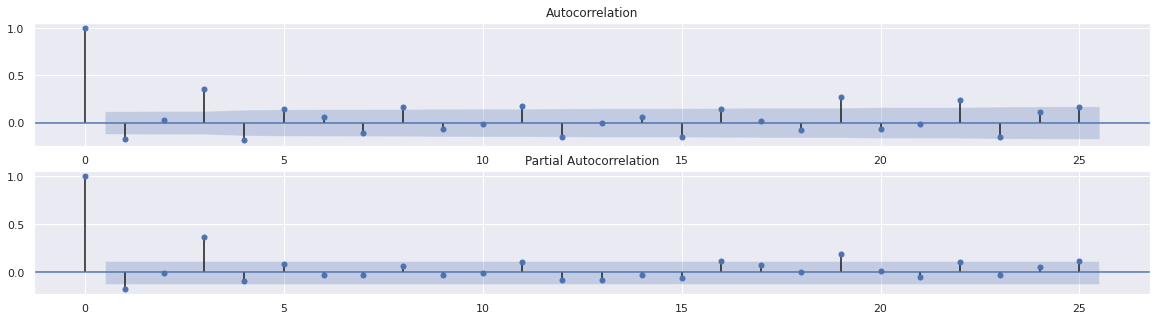

In [423]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(carbondf['Global First Difference'].dropna(),ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(carbondf['Global First Difference'].dropna(),ax=ax2)

CO2 Per GDP

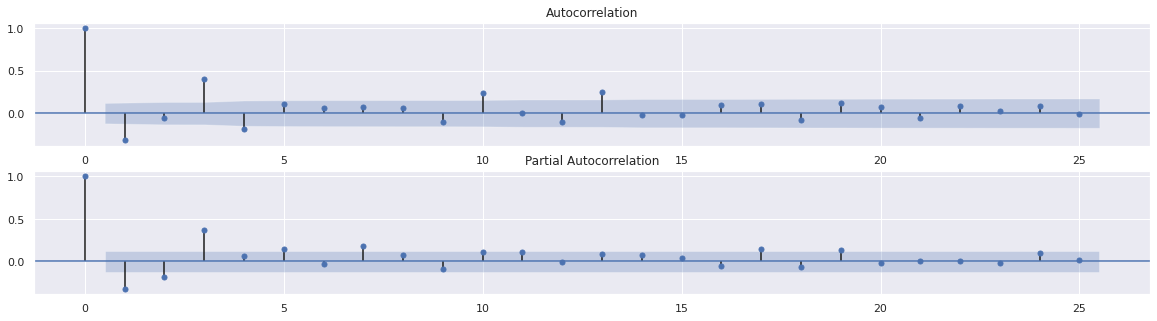

In [424]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(carbondf['GDP First Difference'].dropna(),ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(carbondf['GDP First Difference'].dropna(),ax=ax2)

**pmdarima library**

In [425]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

*CO2*

In [426]:
stepwise_fit = auto_arima(carbondf['co2'],trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=3226.726, Time=0.32 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3416.083, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=3355.873, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=3237.276, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=3233.257, Time=0.22 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=3236.979, Time=0.22 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=3221.813, Time=0.41 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=3221.441, Time=0.53 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=3262.080, Time=0.10 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=3221.950, Time=0.49 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=3264.137, Time=0.04 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=3253.658, Time=0.15 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=3223.813, Time=0.69 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec

Best model:  ARIMA(3,2,1)(0,0,0)[0]  

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  268
Model:               SARIMAX(3, 2, 1)   Log Likelihood               -1605.720
Date:                Fri, 14 May 2021   AIC                           3221.441
Time:                        11:13:51   BIC                           3239.358
Sample:                             0   HQIC                          3228.639
                                - 268                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0088      0.034      0.261      0.794      -0.057       0.075
ar.L2         -0.0943      0.037     -2.536      0.011      -0.167      -0.021
ar.L3          0.2653      0.048      5.553      0.000       0.172       0.359
ma.L1         -0.9804      0.011    -90.366      0.000      -1.002      -0.959
sigma2      1.013e+04    576.274     17.586      0.000    9004.723    1.13e+04
===================================================================================
Ljung-Box (Q):                       86.26   Jarque-Bera (JB):               256.31
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):          832256.17   Skew:                            -1.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

*Share Global*

In [427]:
stepwise_fit = auto_arima(carbondf['share_global_co2'],trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=934.814, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1183.765, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1076.031, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=961.269, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=952.145, Time=0.19 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=954.549, Time=0.10 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=921.654, Time=0.24 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=923.735, Time=0.19 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=923.630, Time=0.39 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=924.587, Time=0.85 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=923.264, Time=0.39 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=922.692, Time=0.23 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=925.568, Time=0.66 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=923.378, Time=0.39 sec

Best model:  ARIMA(3,2,2)(0,0,0)[0]         

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  268
Model:               SARIMAX(3, 2, 2)   Log Likelihood                -454.827
Date:                Fri, 14 May 2021   AIC                            921.654
Time:                        11:14:00   BIC                            943.155
Sample:                             0   HQIC                           930.292
                                - 268                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5280      0.095     -5.531      0.000      -0.715      -0.341
ar.L2         -0.0559      0.044     -1.280      0.200      -0.141       0.030
ar.L3          0.3074      0.040      7.719      0.000       0.229       0.385
ma.L1         -0.5959      0.104     -5.726      0.000      -0.800      -0.392
ma.L2         -0.3595      0.095     -3.779      0.000      -0.546      -0.173
sigma2         1.7687      0.081     21.879      0.000       1.610       1.927
===================================================================================
Ljung-Box (Q):                       49.10   Jarque-Bera (JB):               510.59
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):              49.51   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

*CO2 Per GDP*

In [428]:
stepwise_fit = auto_arima(carbondf['co2_per_gdp'],trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-792.809, Time=0.34 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-448.834, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-569.258, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-704.155, Time=0.11 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-759.326, Time=0.30 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-783.129, Time=0.19 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-791.237, Time=0.50 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=-791.064, Time=0.30 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-744.465, Time=0.27 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=-773.766, Time=0.30 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=-790.174, Time=0.33 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=-789.522, Time=0.57 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-791.226, Time=0.73 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0]          
Total fit time: 4.057 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  268
Model:               SARIMAX(2, 2, 2)   Log Likelihood                 401.404
Date:                Fri, 14 May 2021   AIC                           -792.809
Time:                        11:14:08   BIC                           -774.891
Sample:                             0   HQIC                          -785.610
                                - 268                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0390      0.071    -14.594      0.000      -1.179      -0.899
ar.L2         -0.5748      0.046    -12.398      0.000      -0.666      -0.484
ma.L1         -0.3166      0.083     -3.833      0.000      -0.479      -0.155
ma.L2         -0.5065      0.089     -5.688      0.000      -0.681      -0.332
sigma2         0.0028      0.000     26.494      0.000       0.003       0.003
===================================================================================
Ljung-Box (Q):                       62.34   Jarque-Bera (JB):              1372.36
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):             105.46   Skew:                            -1.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Splitting dataset and training and testing

In [429]:
from statsmodels.tsa.arima_model import ARIMA

In [430]:
print(carbondf.shape)
train = carbondf.iloc[:-30]
test=carbondf.iloc[-30:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1])

(268, 8)
(238, 8) (30, 8)
country                    United States
year                                1989
co2                              4948.02
share_global_co2                  22.334
co2_per_gdp                        0.544
co2 First Difference               62.43
Global First Difference             -0.2
GDP First Difference              -0.012
Name: 22863, dtype: object country                    United States
year                                2018
co2                              5416.28
share_global_co2                   14.81
co2_per_gdp                            0
co2 First Difference             145.529
Global First Difference            0.231
GDP First Difference                   0
Name: 22892, dtype: object


**Training the Model**

*CO2*

In [431]:
model7= ARIMA(train['co2'],order=(3,2,1))
model7 = model7.fit()
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D2.co2   No. Observations:                  236
Model:                 ARIMA(3, 2, 1)   Log Likelihood               -1411.435
Method:                       css-mle   S.D. of innovations             94.636
Date:                Fri, 14 May 2021   AIC                           2834.871
Time:                        11:14:18   BIC                           2855.654
Sample:                             2   HQIC                          2843.249
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3112      0.095      3.273      0.001       0.125       0.498
ar.L1.D2.co2    -0.0224      0.064     -0.348      0.728      -0.148       0.104
ar.L2.D2.co2    -0.1218      0.064     -1.908      0.058      -0.247       0.003
ar.L3.D2.co2     0.2032      0.064      3.165      0.002       0.077       0.329
ma.L1.D2.co2    -1.0000      0.012    -80.761      0.000      -1.024      -0.976
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.6753           -1.4378j            1.5885           -0.3199
AR.2           -0.6753           +1.4378j            1.5885            0.3199
AR.3            1.9498           -0.0000j            1.9498           -0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

*Share Global CO2*

In [433]:
model8= ARIMA(train['share_global_co2'],order=(3,2,2))
model8 = model8.fit()
model8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARIMA Model Results                              
===============================================================================
Dep. Variable:     D2.share_global_co2   No. Observations:                  236
Model:                  ARIMA(3, 2, 2)   Log Likelihood                -415.601
Method:                        css-mle   S.D. of innovations              1.399
Date:                 Fri, 14 May 2021   AIC                            845.201
Time:                         11:15:47   BIC                            869.448
Sample:                              2   HQIC                           854.975
                                                                               
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.0018      0.004     -0.487      0.626      -0.009       0.005
ar.L1.D2.share_global_co2    -0.5499      0.160     -3.436      0.001      -0.864      -0.236
ar.L2.D2.share_global_co2    -0.0729      0.089     -0.817      0.415      -0.248       0.102
ar.L3.D2.share_global_co2     0.2953      0.074      3.997      0.000       0.150       0.440
ma.L1.D2.share_global_co2    -0.5825      0.164     -3.560      0.000      -0.903      -0.262
ma.L2.D2.share_global_co2    -0.3712      0.153     -2.429      0.016      -0.671      -0.072
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8819           -0.9521j            1.2978           -0.3689
AR.2           -0.8819           +0.9521j            1.2978            0.3689
AR.3            2.0107           -0.0000j            2.0107           -0.0000
MA.1            1.0346           +0.0000j            1.0346            0.0000
MA.2           -2.6037           +0.0000j            2.6037            0.5000
-----------------------------------------------------------------------------
"""

In [434]:
model9= ARIMA(train['co2_per_gdp'],order=(2,2,2))
model9 = model9.fit()
model9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D2.co2_per_gdp   No. Observations:                  236
Model:                 ARIMA(2, 2, 2)   Log Likelihood                 359.498
Method:                       css-mle   S.D. of innovations              0.052
Date:                Fri, 14 May 2021   AIC                           -706.995
Time:                        11:15:51   BIC                           -686.212
Sample:                             2   HQIC                          -698.617
                                                                              
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -6.978e-05      0.000     -0.309      0.758      -0.001       0.000
ar.L1.D2.co2_per_gdp    -1.0294      0.104     -9.884      0.000      -1.233      -0.825
ar.L2.D2.co2_per_gdp    -0.5890      0.055    -10.643      0.000      -0.697      -0.481
ma.L1.D2.co2_per_gdp    -0.3764      0.129     -2.913      0.004      -0.630      -0.123
ma.L2.D2.co2_per_gdp    -0.4567      0.128     -3.577      0.000      -0.707      -0.206
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8738           -0.9665j            1.3030           -0.3670
AR.2           -0.8738           +0.9665j            1.3030            0.3670
MA.1            1.1240           +0.0000j            1.1240            0.0000
MA.2           -1.9482           +0.0000j            1.9482            0.5000
-----------------------------------------------------------------------------
"""

Predictions on Test Set

In [435]:
start=len(train)
end=len(train)+len(test)-1
pred=model7.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
pred=model7.predict(start=start,end=end,typ='levels')
pred.index = carbondf.index[start:end+1]
print(pred)

22863    4911.996177
22864    4979.758583
22865    5070.999242
22866    5120.722024
22867    5177.213732
22868    5243.674092
22869    5300.941615
22870    5358.869662
22871    5420.221238
22872    5479.840207
22873    5539.508190
22874    5600.374722
22875    5661.149169
22876    5722.082552
22877    5783.560046
22878    5845.280147
22879    5907.253723
22880    5969.595528
22881    6032.240391
22882    6095.178006
22883    6158.439863
22884    6222.013266
22885    6285.892570
22886    6350.085848
22887    6414.591026
22888    6479.406020
22889    6544.532770
22890    6609.971065
22891    6675.720250
22892    6741.780759
dtype: float64


In [436]:
start=len(train)
end=len(train)+len(test)-1
pred=model8.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
pred=model8.predict(start=start,end=end,typ='levels')
pred.index = carbondf.index[start:end+1]
print(pred)

22863    22.042267
22864    21.968738
22865    21.642432
22866    21.232497
22867    21.008098
22868    20.610782
22869    20.267970
22870    19.960219
22871    19.575802
22872    19.244720
22873    18.897894
22874    18.530842
22875    18.189450
22876    17.828416
22877    17.467982
22878    17.113869
22879    16.748079
22880    16.386067
22881    16.022338
22882    15.653473
22883    15.286314
22884    14.915726
22885    14.543026
22886    14.169883
22887    13.793766
22888    13.416336
22889    13.037356
22890    12.656088
22891    12.273445
22892    11.888910
dtype: float64


In [437]:
start=len(train)
end=len(train)+len(test)-1
pred=model9.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
pred=model9.predict(start=start,end=end,typ='levels')
pred.index = carbondf.index[start:end+1]
print(pred)

22863    0.524802
22864    0.514575
22865    0.501543
22866    0.478864
22867    0.467585
22868    0.450070
22869    0.432077
22870    0.418067
22871    0.400055
22872    0.383634
22873    0.367750
22874    0.350194
22875    0.333859
22876    0.317069
22877    0.299846
22878    0.283155
22879    0.265988
22880    0.248815
22881    0.231746
22882    0.214390
22883    0.197086
22884    0.179715
22885    0.162199
22886    0.144689
22887    0.127076
22888    0.109383
22889    0.091650
22890    0.073823
22891    0.055933
22892    0.037981
dtype: float64


2018 is index number 22892

*CO2*

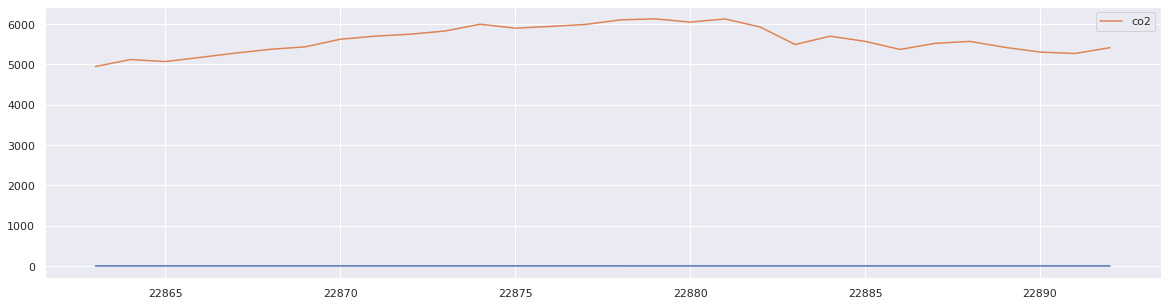

In [438]:
pred.plot(figsize = (20,5))
test['co2'].plot(legend = True)

*Share Global CO2*

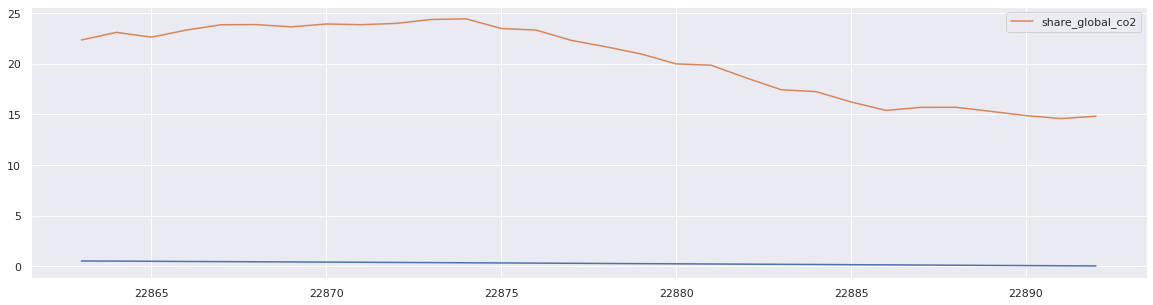

In [439]:
pred.plot(figsize = (20,5))
test['share_global_co2'].plot(legend = True)

*CO2 per GDP*

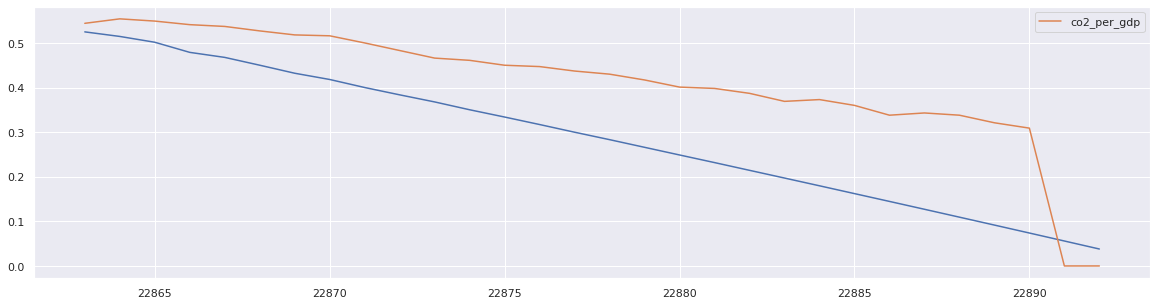

In [440]:
pred.plot(figsize = (20,5))
test['co2_per_gdp'].plot(legend = True)

*CO2*

In [441]:
test['co2'].mean()

5604.596933333333

In [442]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(pred, test['co2']))
print(rmse)

5614.303786530879


root mean squared > mean value hence it is to say that it is a bad model with an average error of 100%

*Share Global*

In [443]:
test['share_global_co2'].mean()

20.349800000000002

In [444]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(pred, test['share_global_co2']))
print(rmse)

20.35303225684903


root mean squared is = mean hence we can say that it is a bad model with an average error of 100%

*CO2 per GDP*

In [445]:
test['co2_per_gdp'].mean()

0.41046666666666654

In [446]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(pred, test['co2_per_gdp']))
print(rmse)

0.1421809795863238


root mean squared < mean with an average error of 24%

**Future Dates**

*CO2*

In [447]:
model7 = ARIMA(carbondf['co2'],order = (3,2,1))
model7 = model7.fit()
carbondf.tail()

,country,year,co2,share_global_co2,co2_per_gdp,co2 First Difference,Global First Difference,GDP First Difference
22888,United States,2014,5572.106,15.693,0.338,49.198,0.006,-0.005
22889,United States,2015,5422.966,15.292,0.321,-149.140,-0.401,-0.017
22890,United States,2016,5306.662,14.875,0.309,-116.304,-0.417,-0.012
22891,United States,2017,5270.749,14.579,0.000,-35.913,-0.296,-0.309
22892,United States,2018,5416.278,14.810,0.000,145.529,0.231,0.000


In [448]:
carbondf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 22625 to 22892
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   country                  268 non-null    object 
 1   year                     268 non-null    int64  
 2   co2                      268 non-null    float64
 3   share_global_co2         268 non-null    float64
 4   co2_per_gdp              268 non-null    float64
 5   co2 First Difference     267 non-null    float64
 6   Global First Difference  267 non-null    float64
 7   GDP First Difference     267 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 18.8+ KB


In [449]:
index_future_dates = pd.date_range(start = '2018', end = '2019')
pred = model7.predict(start = len(carbondf),end=len(carbondf)+30,typ = 'levels').rename('ARIMA Predictions')
#pred.index = index_future_dates
print(pred)

266    5427.576053
267    5442.399087
268    5518.286545
269    5558.797472
270    5594.415046
271    5649.721841
272    5696.398037
273    5740.023247
274    5789.834391
275    5837.847531
276    5884.617746
277    5933.354707
278    5981.907804
279    6030.106794
280    6079.005679
281    6128.056632
282    6177.111229
283    6226.500016
284    6276.093781
285    6325.821035
286    6375.781252
287    6425.947545
288    6476.291361
289    6526.841454
290    6577.593577
291    6628.537404
292    6679.680901
293    6731.023969
294    6782.563114
295    6834.300435
296    6886.236252
Name: ARIMA Predictions, dtype: float64


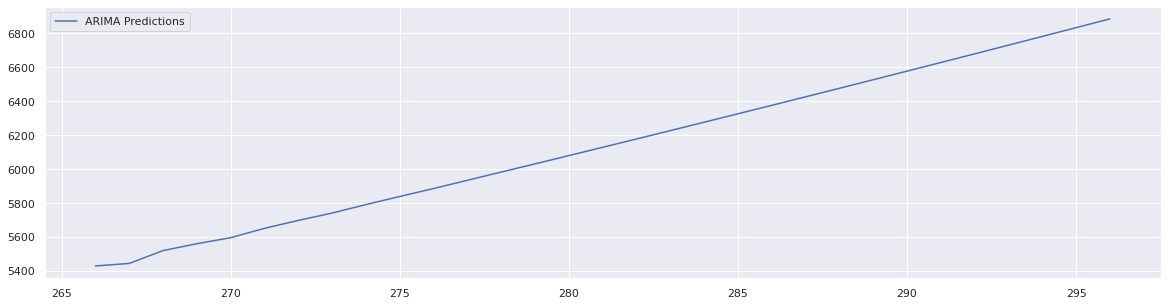

In [450]:
pred.plot(figsize = (20,5),legend = True)

*Share Global*

In [451]:
model8 = ARIMA(carbondf['share_global_co2'],order = (3,2,2))
model8 = model8.fit()
carbondf.tail()

,country,year,co2,share_global_co2,co2_per_gdp,co2 First Difference,Global First Difference,GDP First Difference
22888,United States,2014,5572.106,15.693,0.338,49.198,0.006,-0.005
22889,United States,2015,5422.966,15.292,0.321,-149.140,-0.401,-0.017
22890,United States,2016,5306.662,14.875,0.309,-116.304,-0.417,-0.012
22891,United States,2017,5270.749,14.579,0.000,-35.913,-0.296,-0.309
22892,United States,2018,5416.278,14.810,0.000,145.529,0.231,0.000


In [452]:
index_future_dates = pd.date_range(start = '2018', end = '2019')
pred = model8.predict(start = len(carbondf),end=len(carbondf)+30,typ = 'levels').rename('ARIMA Predictions')
#pred.index = index_future_dates
print(pred)

266    14.367719
267    14.062244
268    13.881730
269    13.417943
270    13.136336
271    12.810789
272    12.408857
273    12.103607
274    11.736010
275    11.370248
276    11.034661
277    10.661762
278    10.305305
279     9.949450
280     9.578766
281     9.218823
282     8.852126
283     8.481719
284     8.114847
285     7.742134
286     7.369055
287     6.995479
288     6.618283
289     6.240805
290     5.861419
291     5.479835
292     5.097325
293     4.712734
294     4.326509
295     3.938872
296     3.549325
Name: ARIMA Predictions, dtype: float64


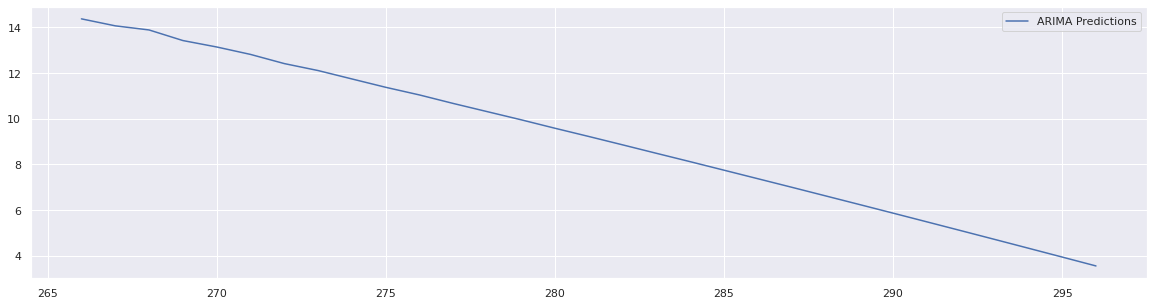

In [454]:
pred.plot(figsize = (20,5),legend = True)

*CO2 per GDP*

In [455]:
model9 = ARIMA(carbondf['co2_per_gdp'],order = (2,2,2))
model9 = model9.fit()
carbondf.tail()

,country,year,co2,share_global_co2,co2_per_gdp,co2 First Difference,Global First Difference,GDP First Difference
22888,United States,2014,5572.106,15.693,0.338,49.198,0.006,-0.005
22889,United States,2015,5422.966,15.292,0.321,-149.140,-0.401,-0.017
22890,United States,2016,5306.662,14.875,0.309,-116.304,-0.417,-0.012
22891,United States,2017,5270.749,14.579,0.000,-35.913,-0.296,-0.309
22892,United States,2018,5416.278,14.810,0.000,145.529,0.231,0.000


In [456]:
index_future_dates = pd.date_range(start = '2018', end = '2019')
pred = model9.predict(start = len(carbondf),end=len(carbondf)+30,typ = 'levels').rename('ARIMA Predictions')
#pred.index = index_future_dates
print(pred)

266    0.031313
267   -0.099836
268   -0.080520
269   -0.124581
270   -0.189641
271   -0.196830
272   -0.252475
273   -0.291405
274   -0.320236
275   -0.369551
276   -0.403764
277   -0.442280
278   -0.485385
279   -0.521628
280   -0.562746
281   -0.603124
282   -0.641850
283   -0.683099
284   -0.723057
285   -0.763288
286   -0.804358
287   -0.844780
288   -0.885775
289   -0.926928
290   -0.967969
291   -1.009417
292   -1.050887
293   -1.092481
294   -1.134315
295   -1.176210
296   -1.218285
Name: ARIMA Predictions, dtype: float64


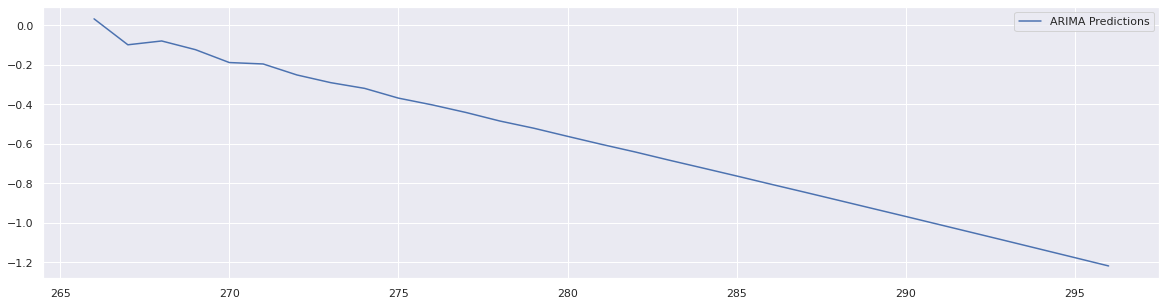

In [457]:
pred.plot(figsize = (20,5),legend = True)